In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.cluster.hierarchy as shc
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from numpy import unique
from numpy import where
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib as mp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Data Reading

In [154]:
df1 = pd.read_csv('./climatic_indices/AO.txt', delimiter=',', header=None)
df2 = pd.read_csv('./climatic_indices/EPO.txt', delimiter=',', header=None)
df3 = pd.read_csv('./climatic_indices/NAO.txt', delimiter=',', header=None)
df4 = pd.read_csv('./climatic_indices/NINO12.txt', delim_whitespace=True, header=None)
df5 = pd.read_csv('./climatic_indices/NINO3.txt', delim_whitespace=True, header=None)
df6 = pd.read_csv('./climatic_indices/NINO34.txt', delim_whitespace=True, header=None)
df7 = pd.read_csv('./climatic_indices/NINO4.txt', delim_whitespace=True, header=None)
df8 = pd.read_csv('./climatic_indices/PNA.txt', delimiter=',', header=None)
df9 = pd.read_csv('./climatic_indices/SOI.txt', delim_whitespace=True)
df10 = pd.read_csv('./climatic_indices/WPO.txt', delimiter=',', header=None)
cle_inf = pd.read_excel('./data/cle/CLE_INFLOW.xlsx')
cle_eva = pd.read_excel('./data/cle/CLE_EVAPORATION.xlsx')
cle_pre = pd.read_excel('./data/cle/CLE_PRECIPITATION.xlsx')

## Data Extraction of Common Timeline

In [155]:
def convert_single_to_datetime(df):
    df.iloc[:, 0] = df.iloc[:, 0].astype(str)
    df['date'] = pd.to_datetime(df.iloc[:, 0], format='%Y%m%d', errors='coerce')
    df.drop(df.columns[0], axis=1, inplace=True)
    return df

def convert_double_to_datetime(df):
    df['date_str'] = df.iloc[:, 0].astype(str) + df.iloc[:, 1].astype(str).str.zfill(3)
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%j', errors='coerce')
    df.drop(df.columns[[0, 1]], axis=1, inplace=True)
    df.drop('date_str', axis=1, inplace=True)
    return df

def convert_triple_to_datetime(df):
    df['date_str'] = df.iloc[:, 0].astype(str) + df.iloc[:, 1].astype(str).str.zfill(2) + df.iloc[:, 2].astype(str).str.zfill(2)
    df['date'] = pd.to_datetime(df['date_str'], format='%Y%m%d', errors='coerce')
    df.drop(df.columns[[0, 1, 2]], axis=1, inplace=True)
    df.drop('date_str', axis=1, inplace=True)
    return df

def convert_column_to_datetime(df, column_name):
    df[column_name] = df[column_name].astype(str)
    df['date'] = pd.to_datetime(df[column_name], format='%Y%m%d', errors='coerce')
    df.drop(columns=[column_name], inplace=True)
    return df


In [156]:
df1

0  1   2         3
0      1950  1   1 -2.511443
1      1950  1   2 -1.505500
2      1950  1   3 -1.173238
3      1950  1   4 -1.250540
4      1950  1   5 -0.125743
...     ... ..  ..       ...
26745  2023  3  24  1.817219
26746  2023  3  25  1.218160
26747  2023  3  26  0.598312
26748  2023  3  27  0.598962
26749  2023  3  28  1.022425

[26750 rows x 4 columns]

In [157]:
df1 = convert_triple_to_datetime(df1)
df2 = convert_triple_to_datetime(df2)
df3 = convert_triple_to_datetime(df3)
df4 = convert_single_to_datetime(df4)
df5 = convert_single_to_datetime(df5)
df6 = convert_single_to_datetime(df6)
df7 = convert_single_to_datetime(df7)
df8 = convert_triple_to_datetime(df8)
df9 = convert_double_to_datetime(df9)
df10 = convert_triple_to_datetime(df10)
cle_inf = convert_column_to_datetime(cle_inf, 'OBS DATE')
cle_eva = convert_column_to_datetime(cle_eva, 'OBS DATE')
cle_pre = convert_column_to_datetime(cle_pre, 'OBS DATE')

In [158]:
def find_min_max_dates(dataframes):
    min_date = dataframes[0]['date'].min()
    max_date = dataframes[0]['date'].max()

    for df in dataframes:
        if 'date' in df.columns:
            df_min_date = df['date'].min()
            df_max_date = df['date'].max()
            min_date = max(min_date, df_min_date)
            max_date = min(max_date, df_max_date)

    return min_date, max_date

dataframes = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, cle_inf, cle_eva, cle_pre]
min_date, max_date = find_min_max_dates(dataframes)

print(min_date)
print(max_date)


1991-06-06 00:00:00
2022-12-31 00:00:00


In [159]:
def reduce_dataframe_by_date_range(df, min_date, max_date):
    mask = (df['date'] >= min_date) & (df['date'] <= max_date)
    reduced_df = df.loc[mask].copy()
    reduced_df.reset_index(drop=True, inplace=True)
    return reduced_df

ao_df = reduce_dataframe_by_date_range(df1, min_date, max_date)
epo_df = reduce_dataframe_by_date_range(df2, min_date, max_date)
nao_df = reduce_dataframe_by_date_range(df3, min_date, max_date)
nino12_df = reduce_dataframe_by_date_range(df4, min_date, max_date)
nino3_df = reduce_dataframe_by_date_range(df5, min_date, max_date)
nino34_df = reduce_dataframe_by_date_range(df6, min_date, max_date)
nino4_df = reduce_dataframe_by_date_range(df7, min_date, max_date)
pna_df = reduce_dataframe_by_date_range(df8, min_date, max_date)
soi_df = reduce_dataframe_by_date_range(df9, min_date, max_date)
wpo_df = reduce_dataframe_by_date_range(df10, min_date, max_date)
cle_inflow_df = reduce_dataframe_by_date_range(cle_inf, min_date, max_date)
cle_evaporation_df = reduce_dataframe_by_date_range(cle_eva, min_date, max_date)
cle_precipitation_df = reduce_dataframe_by_date_range(cle_pre, min_date, max_date)


In [447]:
ao = pd.DataFrame()
epo = pd.DataFrame()
nao = pd.DataFrame()
nino12 = pd.DataFrame()
nino3 = pd.DataFrame()
nino34 = pd.DataFrame()
nino4 = pd.DataFrame()
pna = pd.DataFrame()
soi = pd.DataFrame()
wpo = pd.DataFrame()
cle_inflow = pd.DataFrame()
cle_evaporation = pd.DataFrame()
cle_precipitation = pd.DataFrame()
seasonality = pd.DataFrame()

In [448]:
ao['VALUE'] = ao_df.iloc[:,0]
epo['VALUE'] = epo_df.iloc[:,0]
nao['VALUE'] = nao_df.iloc[:,0]
nino12['VALUE'] = nino12_df.iloc[:,0]
nino3['VALUE'] = nino3_df.iloc[:,0]
nino34['VALUE'] = nino34_df.iloc[:,0]
nino4['VALUE'] = nino4_df.iloc[:,0]
pna['VALUE'] = pna_df.iloc[:,0]
soi['VALUE'] = soi_df['SOI'].copy()
wpo['VALUE'] = wpo_df.iloc[:,0]
cle_inflow['VALUE'] = cle_inflow_df['VALUE'].copy()
cle_evaporation['VALUE'] = cle_evaporation_df['VALUE'].copy()
cle_precipitation['VALUE'] = cle_precipitation_df['VALUE'].copy()
seasonality['VALUE'] = epo_df['date'].dt.month

## Checking if Null Value is Present in DataFrame

In [451]:
are_missing = 0
dfs = [ao, epo, nao, nino12, nino3, nino34, nino4, pna, soi, wpo, cle_inflow, cle_evaporation, cle_precipitation, seasonality]
df_names =  ['AO', 'EPO', 'NAO', 'NINO12', 'NINO3', 'NINO34', 'NINO4', 'PNA', 'SOI', 'WPO', 'cle_inflow', 'cle_precipitation', 'cle_precipitation']
for i, df in enumerate(dfs):
    if df.isna().any().any():
        are_missing = 1
        print(f"{df_names[i]} has NaN values.")

if are_missing == 0:
    print("\nNo missing values in any of the dataframes")

AO has NaN values.
cle_inflow has NaN values.
cle_precipitation has NaN values.
cle_precipitation has NaN values.


## Convert Object Type Data to Float

In [175]:
def converttofloat(s):
  count = 0
  s = str(s)
  v = float(s.replace(',',''))
  if v < 0:
    count +=1
    return np.nan
  else:
    return v

In [176]:
cle_inflow['VALUE'] = cle_inflow['VALUE'].apply(converttofloat)

In [177]:
seasonality['VALUE'] = seasonality['VALUE'].apply(converttofloat)

## Filling Missing Values

In [178]:
cle_inflow['VALUE'].interpolate(method='linear', inplace=True)
cle_evaporation['VALUE'].interpolate(method='linear', inplace = True)
cle_precipitation['VALUE'].interpolate(mehtod = 'linear', inplace=True)
ao['VALUE'].interpolate(method = 'linear', inplace=True)

## Unit conversion

In [179]:
def cfstom3(value):
    value = value*0.0283168466
    return value

In [180]:
def inchestomm(value):
    value = value*25.4
    return value

In [181]:
cle_inflow['VALUE'] = cle_inflow['VALUE'].apply(cfstom3)
cle_evaporation['VALUE'] = cle_evaporation['VALUE'].apply(cfstom3)
cle_precipitation['VALUE'] = cle_precipitation['VALUE'].apply(inchestomm)

## Data Visualization

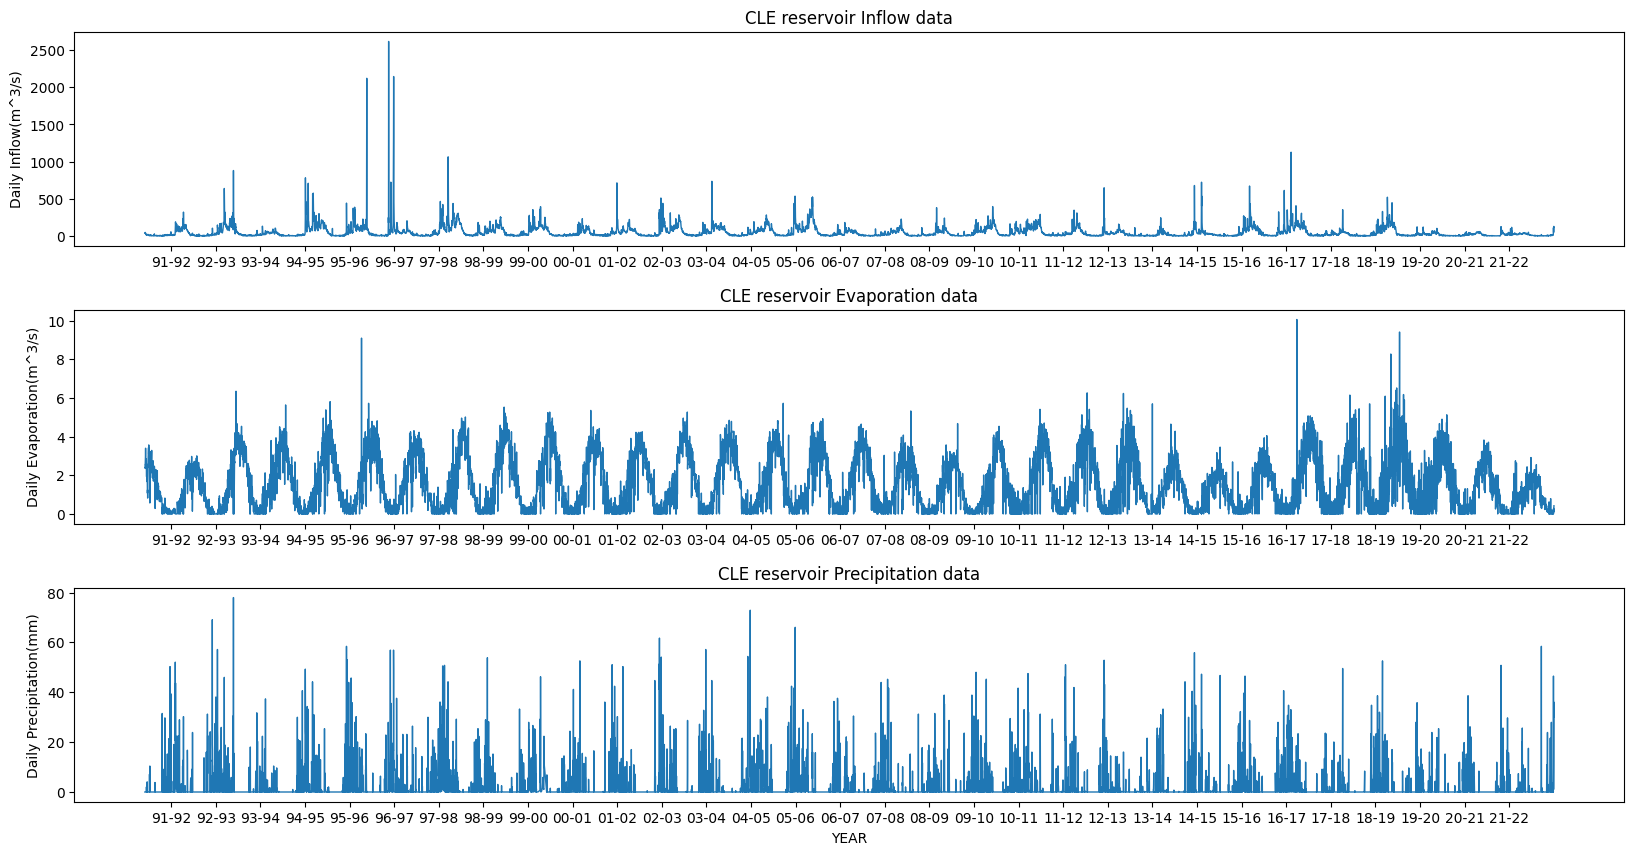

In [182]:
a = list(cle_inflow['VALUE'])
b = list(cle_evaporation['VALUE'])
c = list(cle_precipitation['VALUE'])
fig,ax =  plt.subplots(3,1,figsize=(20,10))
plt.setp(ax, xticks=[ 215,  580,  945, 1310, 1675, 2040, 2405, 2770, 3135, 3500, 3865, 4230, 4595, 4960, 5325, 5690, 6055, 6420, 6785, 7150, 7515, 7880, 8245, 8610, 8975, 9340, 9705, 10070, 10435, 10800, 11165],
         xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
ax[0].plot(a,linewidth=1)
ax[0].set_title('CLE reservoir Inflow data')
ax[0].set_ylabel('Daily Inflow(m^3/s)')
ax[1].plot(b,linewidth=1)
ax[1].set_title('CLE reservoir Evaporation data')
ax[1].set_ylabel('Daily Evaporation(m^3/s)')
ax[2].plot(c,linewidth=1)
ax[2].set_title('CLE reservoir Precipitation data')
ax[2].set_ylabel('Daily Precipitation(mm)')
plt.xlabel('YEAR')
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig("CLE.png")
plt.show()

In [183]:
cle = pd.DataFrame({'inflow':a,'evaporation':b,'precipitation':c})
cle.to_csv('cle.csv')

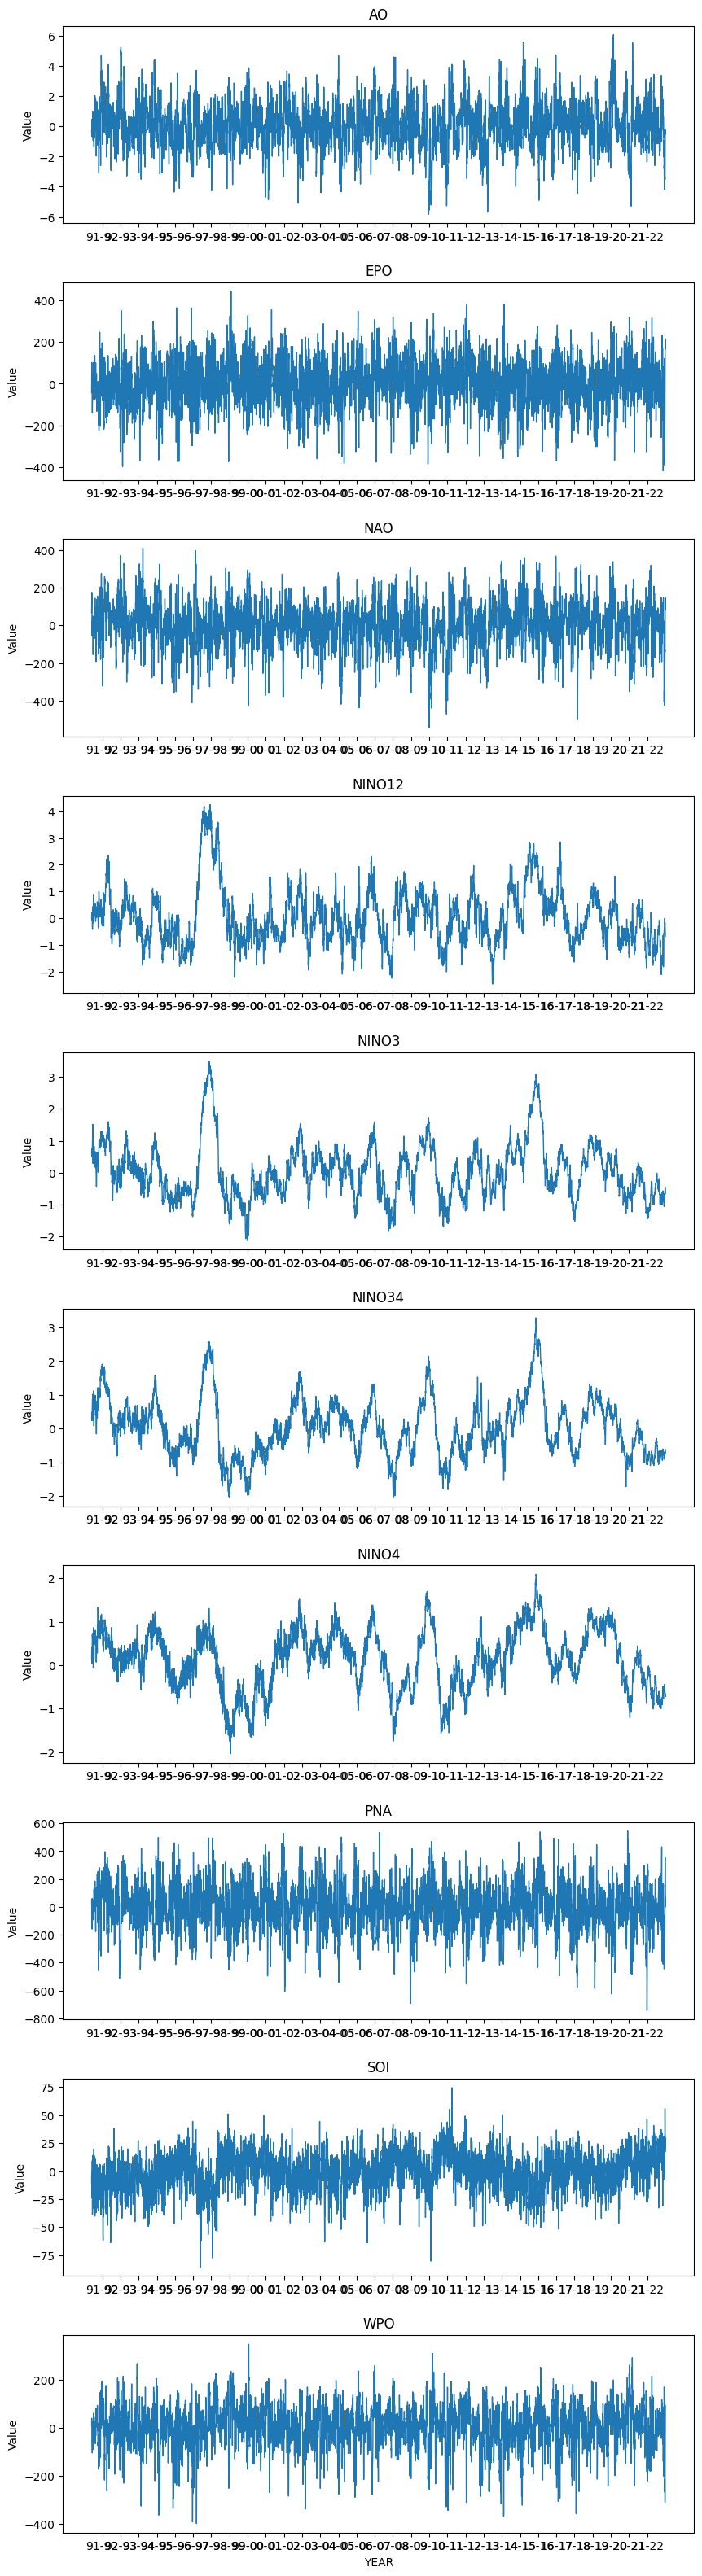

In [437]:
# plot climatic indices
fig,ax = plt.subplots(10,1,figsize=(10,40))
plt.setp(ax, xticks=np.arange(215,11318,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
names = ['AO', 'EPO', 'NAO', 'NINO12', 'NINO3', 'NINO34', 'NINO4', 'PNA', 'SOI', 'WPO']
for i, index in enumerate([ao, epo, nao, nino12, nino3, nino34, nino4, pna, soi, wpo]):
    ax[i].plot(index,linewidth=1)
    ax[i].set_title(names[i])
    ax[i].set_ylabel('Value')

plt.xlabel('YEAR')
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

## Checking Autocorrelation

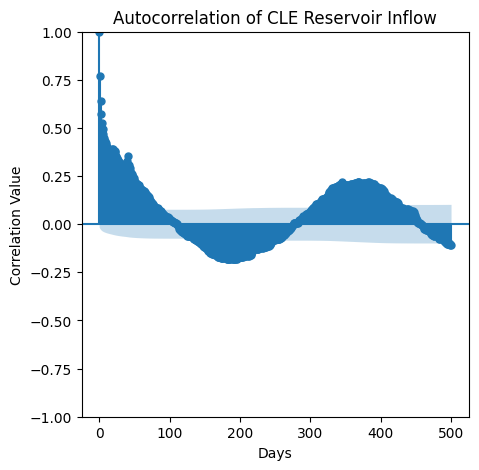

In [198]:
with mp.rc_context():
  mp.rc("figure",figsize=(5,5))
  plot_acf(cle_inflow,lags=500)
  plt.title('Autocorrelation of CLE Reservoir Inflow')
  plt.ylabel('Correlation Value')
  plt.xlabel('Days')
  plt.show()

/home/joelalex/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


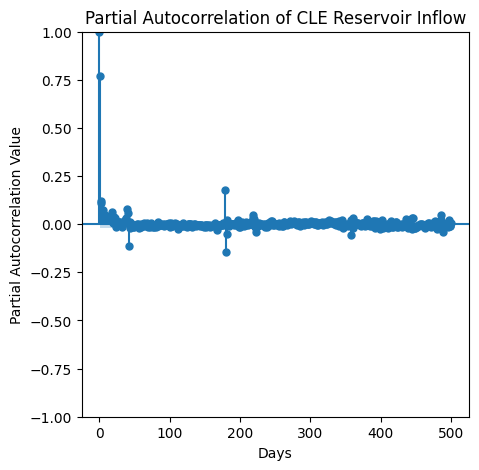

In [199]:
with mp.rc_context():
  mp.rc("figure",figsize=(5,5))
  plot_pacf(cle_inflow,lags=500)
  plt.title('Partial Autocorrelation of CLE Reservoir Inflow')
  plt.ylabel('Partial Autocorrelation Value')
  plt.xlabel('Days')
  plt.show()

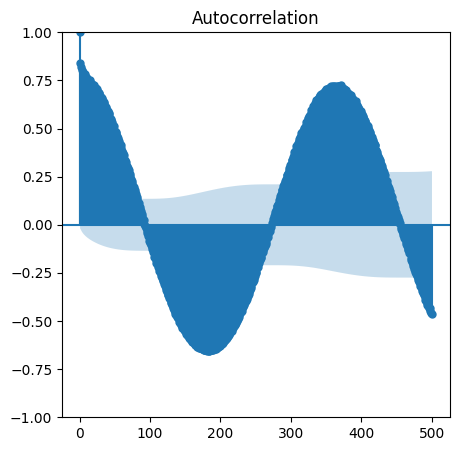

In [200]:
with mp.rc_context():
  mp.rc("figure",figsize=(5,5))
  plot_acf(cle_evaporation,lags=500)
  plt.show()

/home/joelalex/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


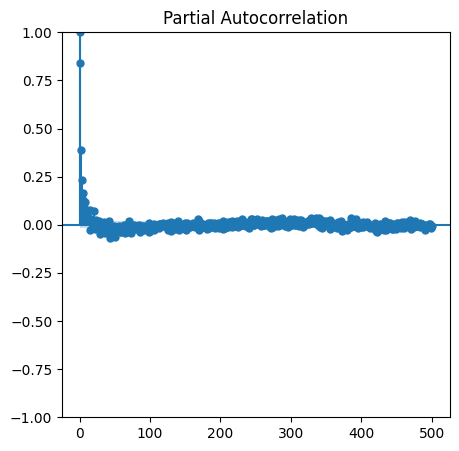

In [201]:
with mp.rc_context():
  mp.rc("figure",figsize=(5,5))
  plot_pacf(cle_evaporation,lags=500)
  plt.show()

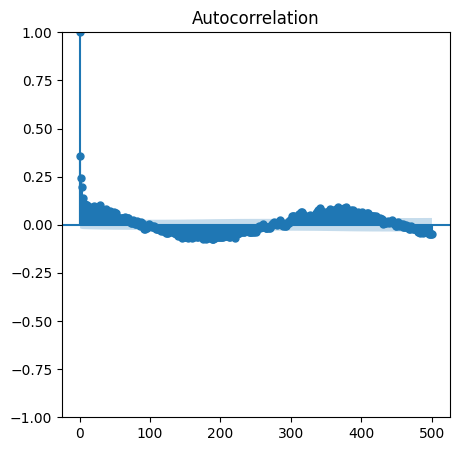

In [202]:
with mp.rc_context():
  mp.rc("figure",figsize=(5,5))
  plot_acf(cle_precipitation,lags=500)
  plt.show()

/home/joelalex/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


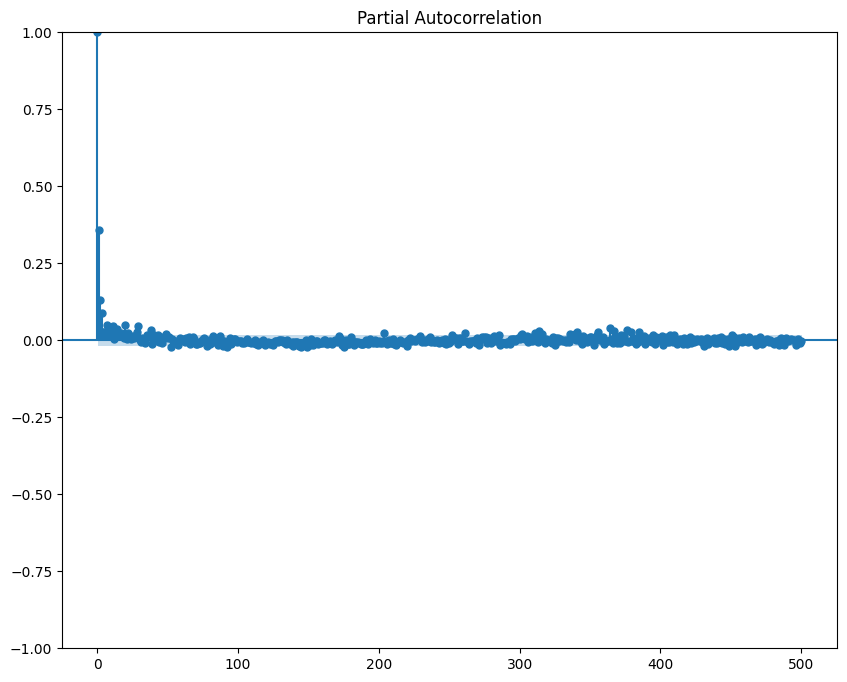

In [203]:
with mp.rc_context():
  mp.rc("figure",figsize=(10,8))
  plot_pacf(cle_precipitation,lags=500)
  plt.show()

## Preparing Lagged Dataset

In [350]:
def generate_lagged_data(data, data_name, time_lag):
    data_lag = pd.DataFrame()
    for i in range(time_lag-1,0,-1):
        data_lag[data_name+'-'+str(i)] = data.shift(i).values[:,0]
    data_lag[data_name] = data.values[:,0]
    data_lag = data_lag[time_lag:]
    return data_lag

ao_lag = generate_lagged_data(ao, 'ao_t', 3)
epo_lag = generate_lagged_data(epo, 'epo_t', 3)
nao_lag = generate_lagged_data(nao, 'nao_t', 3)
nino12_lag = generate_lagged_data(nino12, 'nino12_t', 3)
nino3_lag = generate_lagged_data(nino3, 'nino3_t', 3)
nino34_lag = generate_lagged_data(nino34, 'nino34_t', 3)
nino4_lag = generate_lagged_data(nino4, 'nino4_t', 3)
pna_lag = generate_lagged_data(pna, 'pna_t', 3)
soi_lag = generate_lagged_data(soi, 'soi_t', 3)
wpo_lag = generate_lagged_data(wpo, 'wpo_t', 3)
seasonality_lag = generate_lagged_data(seasonality, 'seasonality_t', 3)
cle_evaporation_lag = generate_lagged_data(cle_evaporation, 'evaporation_t', 3)
cle_precipitation_lag = generate_lagged_data(cle_precipitation, 'precipitation_t', 3)


In [351]:
cle_precipitation_lag.isna()

precipitation_t-2  precipitation_t-1  precipitation_t
3                  False              False            False
4                  False              False            False
5                  False              False            False
6                  False              False            False
7                  False              False            False
...                  ...                ...              ...
11527              False              False            False
11528              False              False            False
11529              False              False            False
11530              False              False            False
11531              False              False            False

[11529 rows x 3 columns]

In [352]:
inflow = pd.DataFrame()
cle_inflow_lag = pd.DataFrame()
for i in range(2,0,-1):
	cle_inflow_lag['inflow_t-'+str(i)] = cle_inflow.shift(i).values[:,0]
cle_inflow_lag = cle_inflow_lag[3:]
inflow['VALUE'] = cle_inflow.values[:,0]
inflow = inflow[3:]

## Formatting Dataset

In [353]:
df_list = [ao_lag,epo_lag,nao_lag,nino12_lag,nino3_lag,nino34_lag,nino4_lag,pna_lag,soi_lag,wpo_lag,seasonality_lag,cle_evaporation_lag,cle_precipitation_lag,cle_inflow_lag]
X = pd.concat(df_list,axis=1, join='inner')
y = inflow.copy()

X.interpolate(method='linear', inplace=True)

## Pearsons Correlation

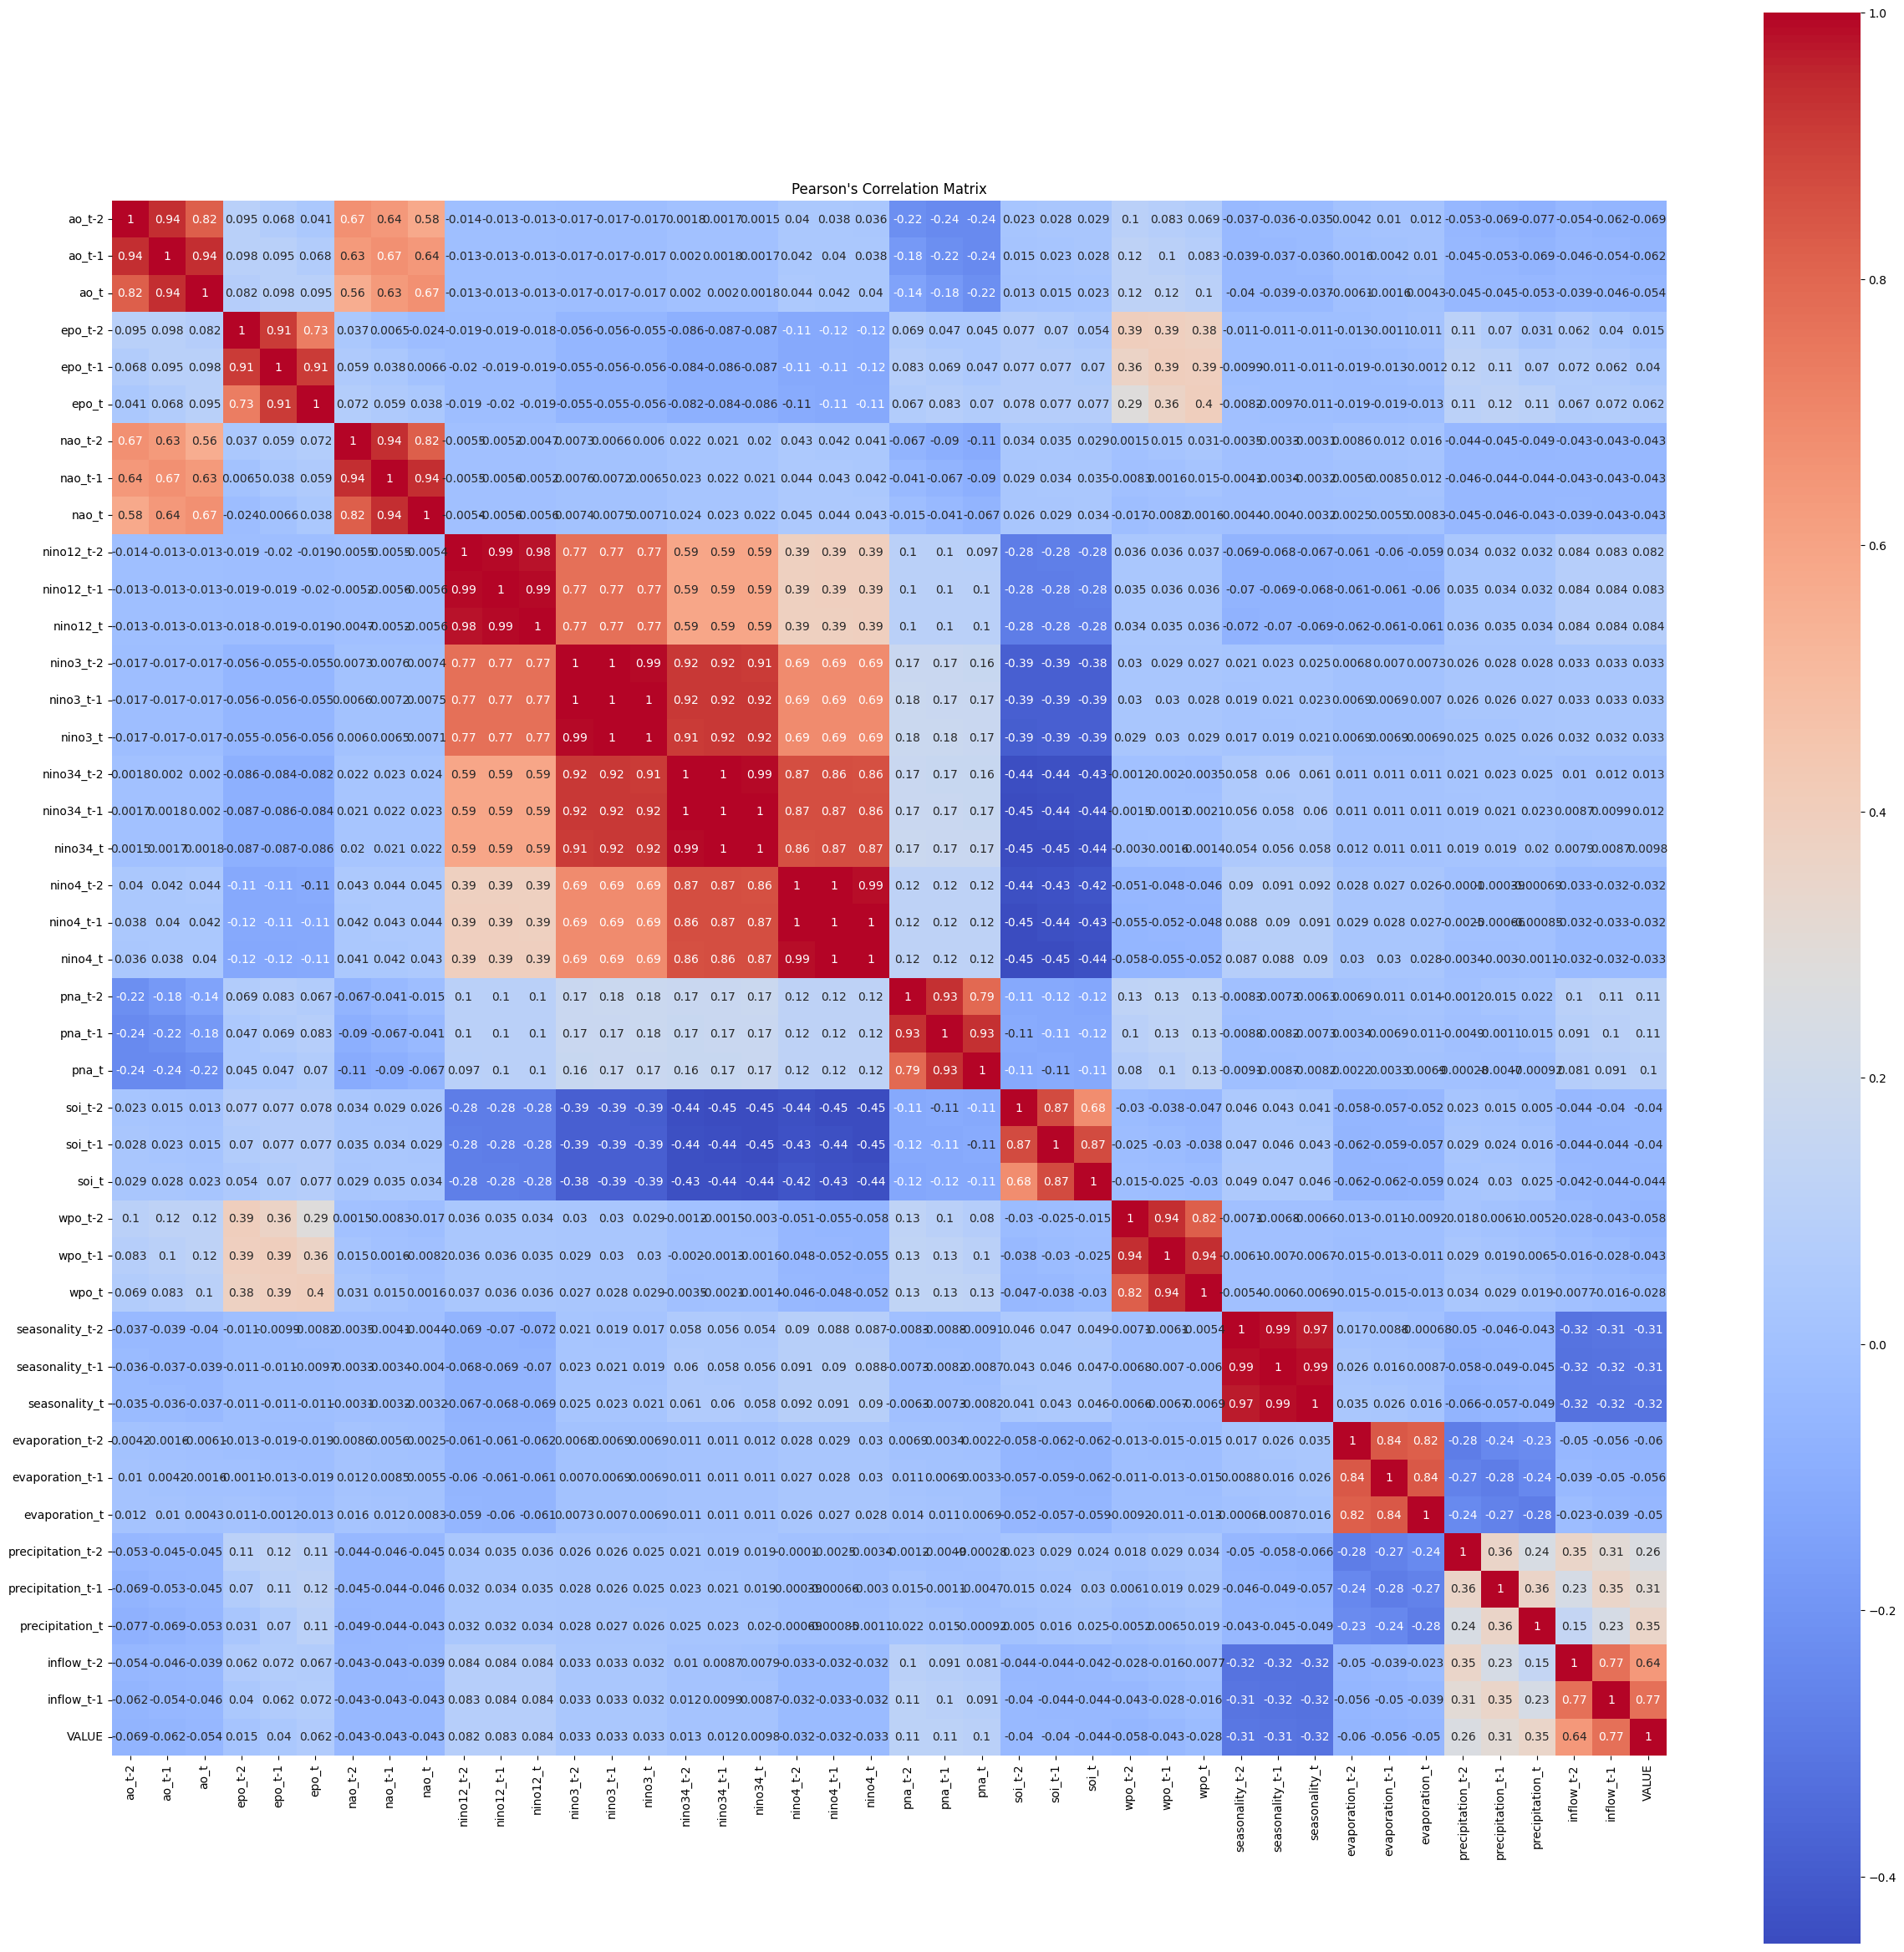

In [354]:
df = pd.concat([X, y],axis=1)
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Pearson's Correlation Matrix")
plt.show()

In [355]:
columns_to_drop = ['wpo_t', 'nino4_t-1', 'nino4_t-2', 'nino34_t', 'nino34_t-1', 'epo_t-2']
negative_columns = ['seasonality_t', 'seasonality_t-1', 'seasonality_t-2', 'wpo_t-2', 'soi_t', 'ao_t-1', 'ao_t-2', 'nao_t-1','nao_t-2']
X = X.drop(columns=columns_to_drop)

## StandardScaler

In [356]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

## Feature Pruning via Gini Impurity

In [357]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_scaler, np.array(y['VALUE']))

importances = regressor.feature_importances_
feature_ranking = sorted(zip(importances, range(len(importances))), reverse=True)

def prune_features(feature_ranking, threshold):
    pruned_features = []
    for importance, index in feature_ranking:
        if importance >= threshold:
            pruned_features.append(index)
        else:
            break
    return pruned_features

threshold = 0.03
pruned_features = prune_features(feature_ranking, threshold)

X_pca = X_scaler[:, pruned_features]


In [358]:
# pca = PCA().fit(X_scaler)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('PCA for CLE Resercoir')
# plt.grid()
# plt.show()

In [359]:
## Number of Components taken 15 considering these 15 contans almost 95% variance

# pca = PCA(n_components=15)
# X_pca = pca.fit_transform(X_scaler)

In [360]:
def correlation(s, o):
    if s.size == 0:
        corr = np.NaN
    else:
        corr = np.corrcoef(o, s)[0,1]
    return corr

def NS(s, o):
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

def KGE(s, o):
    cc = correlation(s,o)
    alpha = np.std(s)/np.std(o)
    beta = np.sum(s)/np.sum(o)
    kge = 1- np.sqrt( (cc-1)**2 + (alpha-1)**2 + (beta-1)**2 )
    return kge

from scipy.stats import pearsonr
def CORR(s,o):
  corr, _ = pearsonr(o,s)
  return corr

def Absolute_Percentage_Error(s,o):
  return (np.sum(np.abs(s-o))/np.sum(o))*100

## Random Forest

In [361]:
from sklearn.ensemble import RandomForestRegressor

**n_estimators = 500 min_samples = 29**

In [362]:
rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_500_29 = []
r_rf_500_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_500_29.extend(y_list_pred)
    r_rf_500_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


In [363]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.5662612086943
CORR  0.8785375599791512
R2  0.7647081690917898
MAE  12.168004288017855
APB  25.33464833244816


**n_estimators = 500* min_samples_leaf = 31**

In [364]:
rf = RandomForestRegressor(n_estimators=500,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_500_31 = []
r_rf_500_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_500_31.extend(y_list_pred)
    r_rf_500_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


In [365]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.70976992759236
CORR  0.8774917340553415
R2  0.7622333791374717
MAE  12.196377343604448
APB  25.39579971689506


**n_estimators = 600 min_samples_leaf = 29**

In [366]:
rf = RandomForestRegressor(n_estimators=600,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_600_29 = []
r_rf_600_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_600_29.extend(y_list_pred)
    r_rf_600_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


In [367]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.60660374758496
CORR  0.8782587105759131
R2  0.7644854626996384
MAE  12.18761812964036
APB  25.36839327832652


**n_estimators = 600 min_samples_leaf = 31**

In [368]:
rf = RandomForestRegressor(n_estimators=600,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_600_31 = []
r_rf_600_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_600_31.extend(y_list_pred)
    r_rf_600_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:26<00:00,  1.80s/it]


In [369]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.64374917947059
CORR  0.8781423493368162
R2  0.7633153967617822
MAE  12.184844011753407
APB  25.357117542290638


**n_estimators = 700 min_samples_leaf = 29**

In [370]:
rf = RandomForestRegressor(n_estimators=700,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_700_29 = []
r_rf_700_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_700_29.extend(y_list_pred)
    r_rf_700_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:26<00:00,  1.73s/it]


In [371]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.556029418734624
CORR  0.8787384045601816
R2  0.7652234547347405
MAE  12.167244474917531
APB  25.324305713017583


**n_estimators =700 min_samples=31**

In [372]:
rf = RandomForestRegressor(n_estimators=700,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_700_31 = []
r_rf_700_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_700_31.extend(y_list_pred)
    r_rf_700_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:24<00:00,  1.60s/it]


In [373]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.72890442554214
CORR  0.877548840481388
R2  0.7626339578949612
MAE  12.19483587238919
APB  25.390095189384972


**n_estimators=800 min_samples= 29**

In [374]:
rf = RandomForestRegressor(n_estimators=800,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_800_29 = []
r_rf_800_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_800_29.extend(y_list_pred)
    r_rf_800_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


In [375]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.548257857368064
CORR  0.8786123695780781
R2  0.7653006012498237
MAE  12.170197527481813
APB  25.333075187634833


**n_estimators=800 min_samples=31**

In [376]:
rf = RandomForestRegressor(n_estimators=800,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_800_31 = []
r_rf_800_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_800_31.extend(y_list_pred)
    r_rf_800_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it]


In [377]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.644690063276315
CORR  0.8780338555955072
R2  0.7638518280377011
MAE  12.186511530972208
APB  25.37564007569939


**n_estimators=900 min_samples=29**

In [378]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_900_29 = []
r_rf_900_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_900_29.extend(y_list_pred)
    r_rf_900_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:33<00:00,  2.26s/it]


In [379]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.57163209653537
CORR  0.8784402928941533
R2  0.7643758171184224
MAE  12.173888474156314
APB  25.34697375808114


**n_estimators=900 min_samples=31**

In [380]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_900_31 = []
r_rf_900_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_900_31.extend(y_list_pred)
    r_rf_900_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:32<00:00,  2.16s/it]


In [381]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.66329500245985
CORR  0.8778805106326256
R2  0.763547313210454
MAE  12.169289233863323
APB  25.349407339611986


**n_estimators=1000 min_samples=29**

In [382]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_1000_29 = []
r_rf_1000_29 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_1000_29.extend(y_list_pred)
    r_rf_1000_29.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:36<00:00,  2.46s/it]


In [383]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.59908681745204
CORR  0.8783190222204936
R2  0.7646108607898484
MAE  12.17754945401839
APB  25.344347290532635


**n_estimators=1000 min_samples=31**

In [384]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1,min_samples_leaf=31,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_100_29 = []
corr_rf_100_29 = []
r2_rf_100_29 = []
mae_rf_100_29 = []
apb_rf_100_29 = []
p_rf_1000_31 = []
r_rf_1000_31 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    p_rf_1000_31.extend(y_list_pred)
    r_rf_1000_31.extend(y_real_list)
    rmse_rf_100_29.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_100_29.append(correlation(y_real,y_pred))
    r2_rf_100_29.append(r2_score(y_real,y_pred))
    mae_rf_100_29.append(mean_absolute_error(y_real,y_pred))
    apb_rf_100_29.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


In [385]:
print('RMSE ',mean(rmse_rf_100_29))
print('CORR ',mean(corr_rf_100_29))
print('R2 ',mean(r2_rf_100_29))
print('MAE ',mean(mae_rf_100_29))
print('APB ',mean(apb_rf_100_29))

RMSE  35.63167804847651
CORR  0.8781680878041768
R2  0.7641228593999339
MAE  12.168122154025305
APB  25.336973621145418


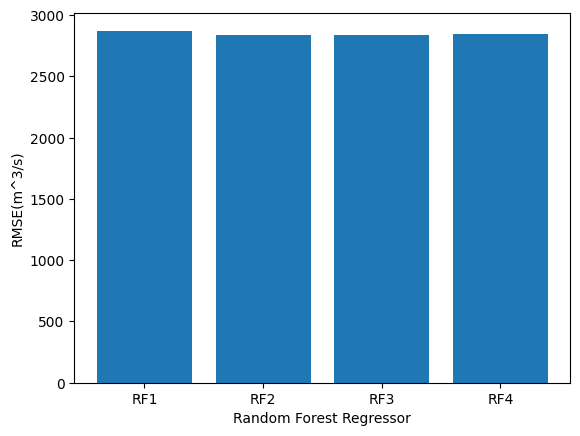

In [386]:
D = {'RF1':2873.209675403621,'RF2':2839.750828563568,'RF3':2840.2114644614076,'RF4':2848.812038003635}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('Random Forest Regressor')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

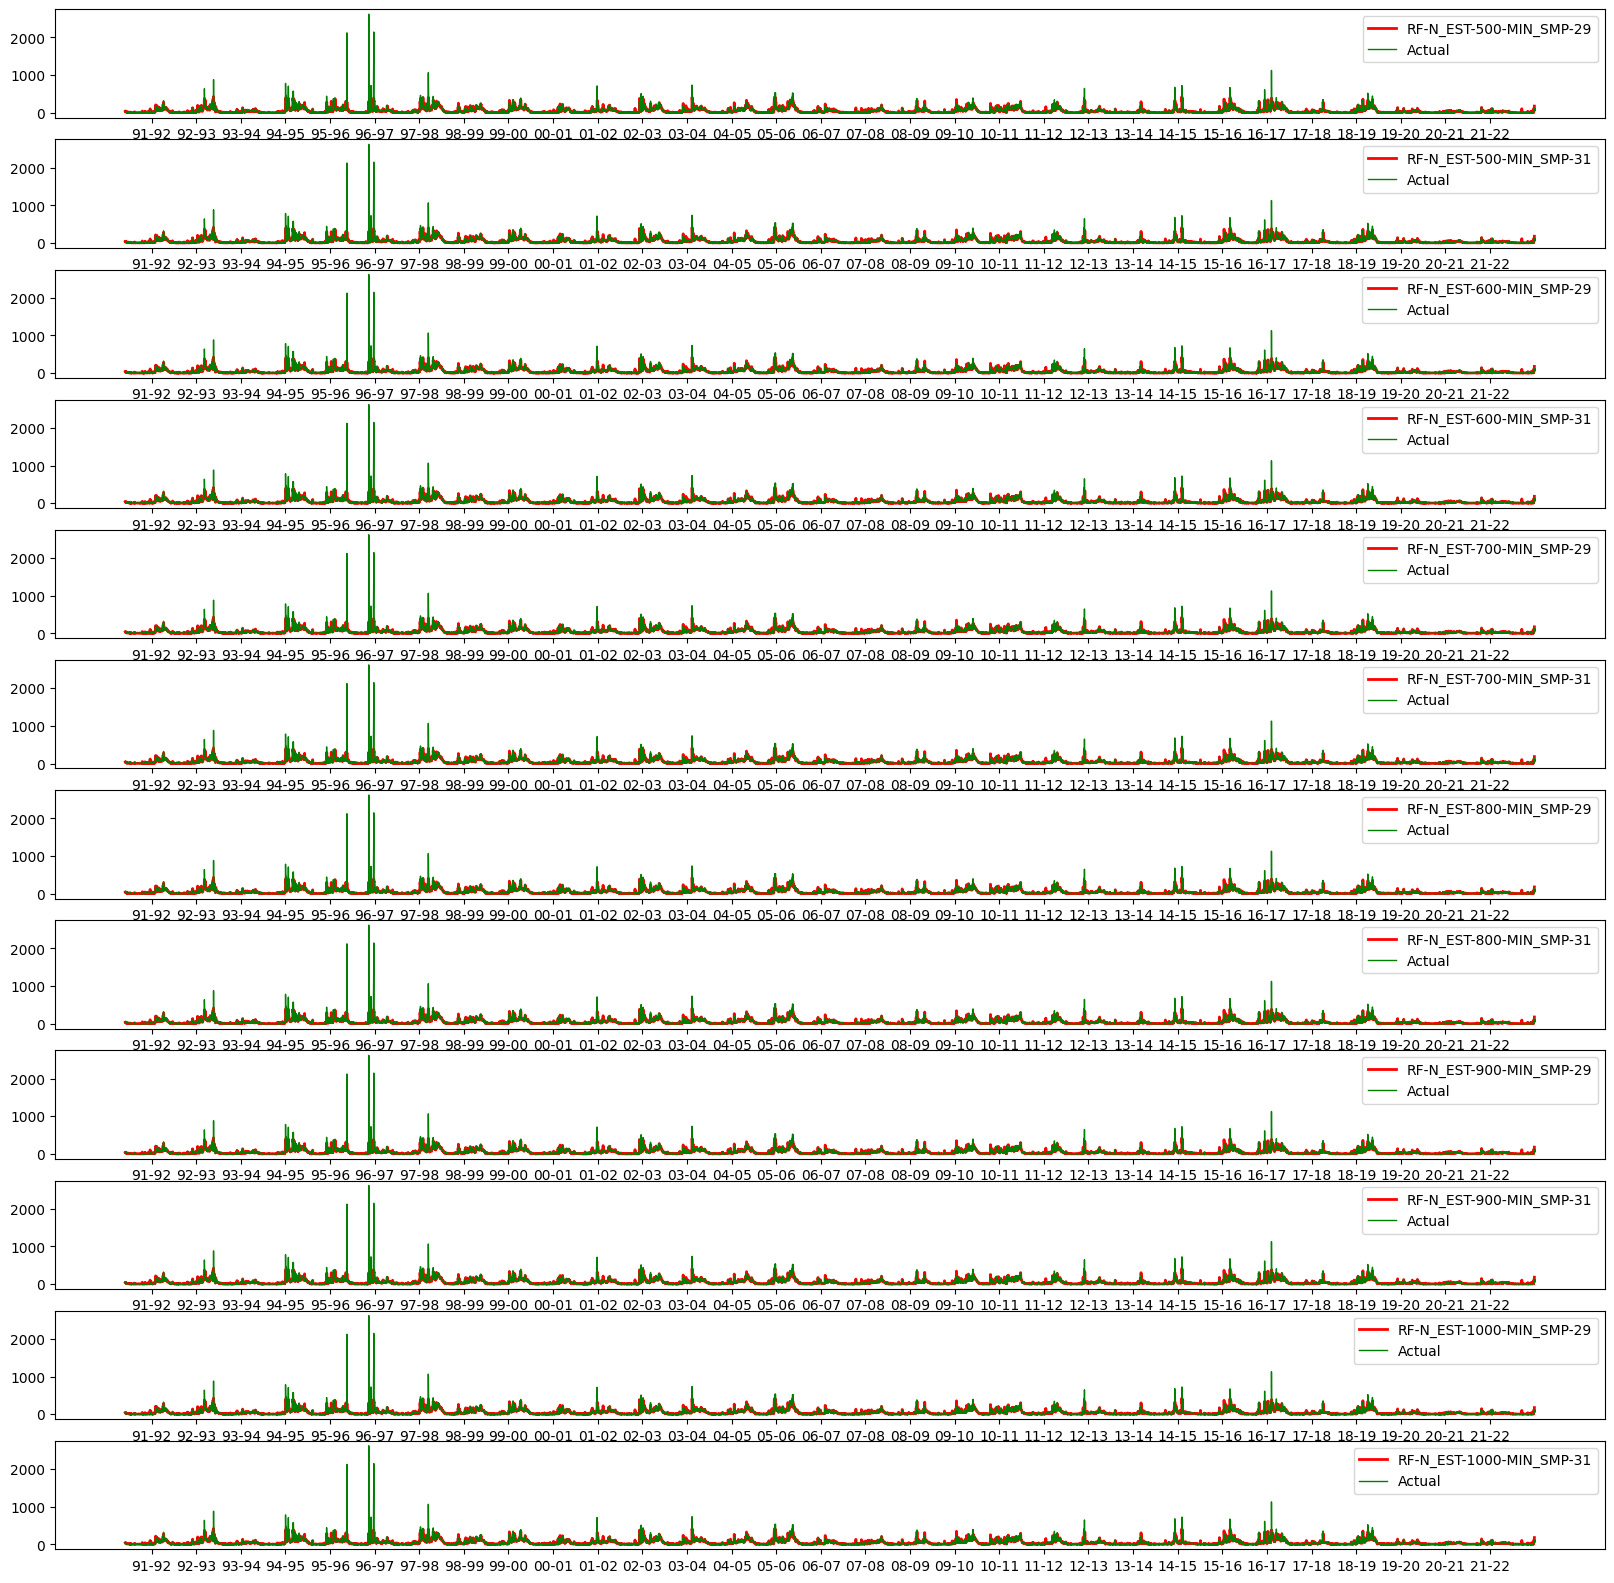

In [387]:
fig,ax = plt.subplots(12,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,11318,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
ax[0].plot(p_rf_500_29,"red",label='RF-N_EST-500-MIN_SMP-29',linewidth=2.0)
ax[0].plot(r_rf_500_29,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_rf_500_31,"red",label='RF-N_EST-500-MIN_SMP-31',linewidth=2.0)
ax[1].plot(r_rf_500_31,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_rf_600_29,"red",label='RF-N_EST-600-MIN_SMP-29',linewidth=2.0)
ax[2].plot(r_rf_600_29,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_rf_600_31,"red",label='RF-N_EST-600-MIN_SMP-31',linewidth=2.0)
ax[3].plot(r_rf_600_31,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=2.0)
ax[4].plot(r_rf_700_29,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_rf_700_31,"red",label='RF-N_EST-700-MIN_SMP-31',linewidth=2.0)
ax[5].plot(r_rf_700_31,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_rf_800_29,"red",label='RF-N_EST-800-MIN_SMP-29',linewidth=2.0)
ax[6].plot(r_rf_800_29,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_rf_800_31,"red",label='RF-N_EST-800-MIN_SMP-31',linewidth=2.0)
ax[7].plot(r_rf_800_31,"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_rf_900_29,"red",label='RF-N_EST-900-MIN_SMP-29',linewidth=2.0)
ax[8].plot(r_rf_900_29,"green",label='Actual',linewidth=1.0)
ax[8].legend()
ax[9].plot(p_rf_900_31,"red",label='RF-N_EST-900-MIN_SMP-31',linewidth=2.0)
ax[9].plot(r_rf_900_31,"green",label='Actual',linewidth=1.0)
ax[9].legend()
ax[10].plot(p_rf_1000_29,"red",label='RF-N_EST-1000-MIN_SMP-29',linewidth=2.0)
ax[10].plot(r_rf_1000_29,"green",label='Actual',linewidth=1.0)
ax[10].legend()
ax[11].plot(p_rf_1000_31,"red",label='RF-N_EST-1000-MIN_SMP-31',linewidth=2.0)
ax[11].plot(r_rf_1000_31,"green",label='Actual',linewidth=1.0)
ax[11].legend()
plt.show()

##Final Random Forest

In [388]:
rf = RandomForestRegressor(n_estimators=900,n_jobs=-1,min_samples_leaf=29,max_features='sqrt')
kf = KFold(n_splits=15,shuffle=False)
rmse_rf_300 = []
corr_rf_300 = []
r2_rf_300 = []
mae_rf_300 = []
predictions_rf = []
real_rf = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    rf.fit(X_train, y_train)
    y_list_pred = list(rf.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_real_list = list(y_test['VALUE'])
    y_real = np.array(y_real_list)
    rmse_rf_300.append(math.sqrt(mean_squared_error(y_real,y_pred)))
    corr_rf_300.append(correlation(y_real,y_pred))
    r2_rf_300.append(r2_score(y_real,y_pred))
    mae_rf_300.append(mean_absolute_error(y_real,y_pred))
    predictions_rf.extend(y_list_pred)
    real_rf.extend(y_real_list)

k-fold: 100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


**Daily Accuracy**

In [389]:
print('RMSE ', mean(rmse_rf_300))
# print('Monthly NS ', mean(ns_rf_300))
# print('Monthly KGE ', mean(kge_rf_300))
print('CORR ', mean(corr_rf_300))
print('R2 ',mean(r2_rf_300))
print('MAE ',mean(mae_rf_300))

RMSE  35.62568900083189
CORR  0.878235353794654
R2  0.7635544389024944
MAE  12.183425679996715


**Monthly Accuracy**

In [390]:
a = predictions_rf[24:-4]
b = real_rf[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
# print('Monthly NS ',NS(np.array(r),np.array(p)))
# print('Monthly KGE ',KGE(np.array(r),np.array(p)))
print('Monthly CORR ',correlation(np.array(r),np.array(p)))
print('Monthly R2 ',r2_score(r,p))
print('Monthly MAE ',mean_absolute_error(r,p))

Monthly RMSE  10.778120944114667
Monthly CORR  0.9829687929402735
Monthly R2  0.9623325273308332
Monthly MAE  4.167351593639164


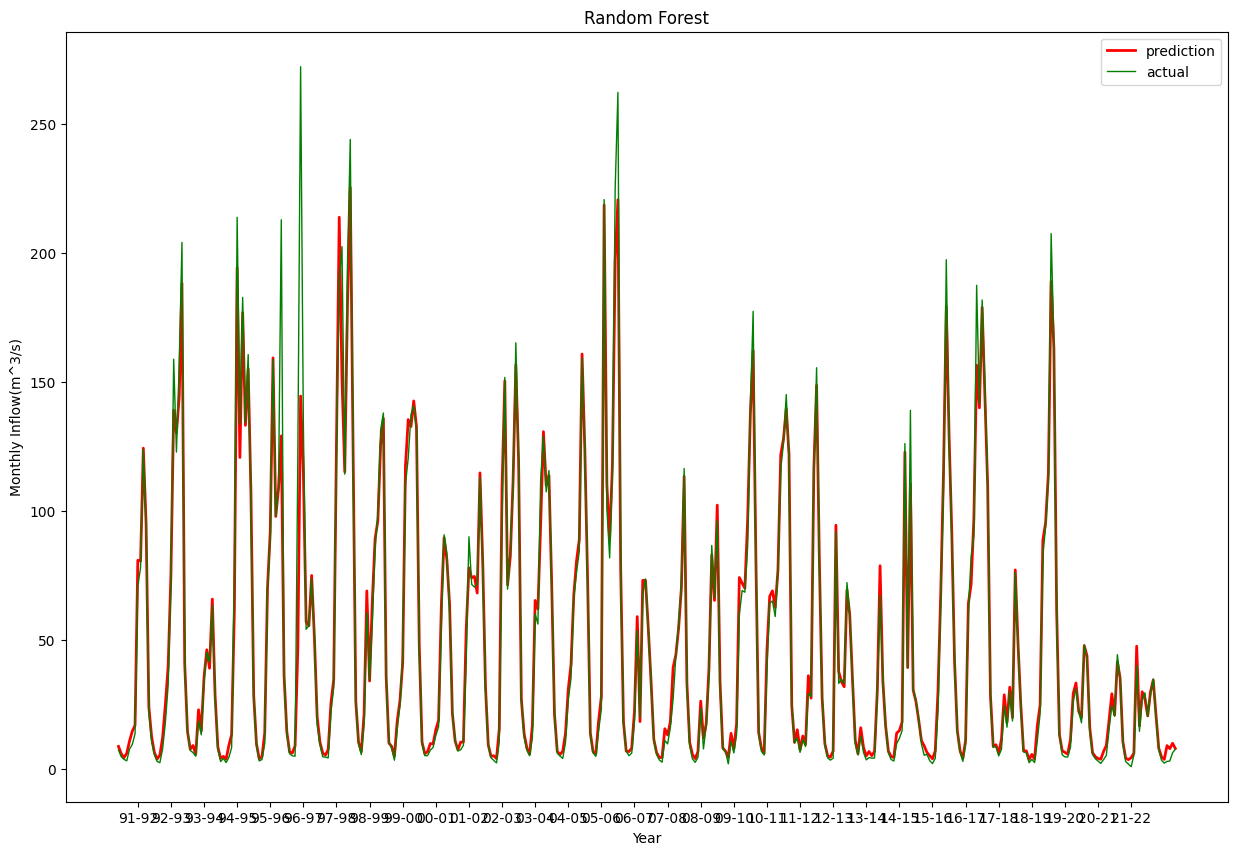

In [391]:
a = predictions_rf[24:-4]
b = real_rf[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,374,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("Random Forest")
plt.show()

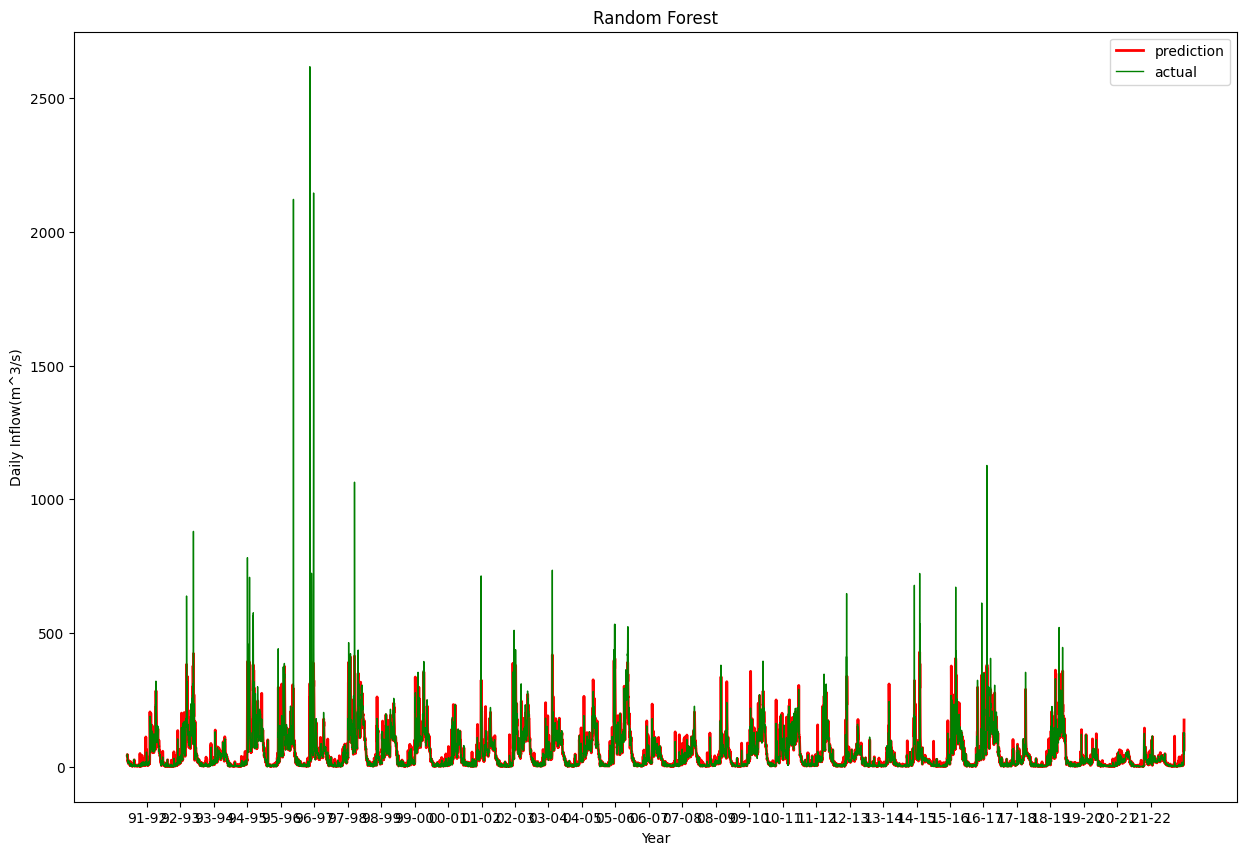

In [392]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_rf, "red", label="prediction", linewidth=2.0)
plt.plot(real_rf, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,11318,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("Random Forest")
plt.show()

## Gradient Boosting Regressor

In [393]:
from sklearn.ensemble import GradientBoostingRegressor

**n_est=100 min_samples=10**

In [394]:
gbr = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_100_10 = []
p_gbr_100_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_100_10.extend(y_list_real)
    p_gbr_100_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


In [395]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  35.17265993227928
CORR  0.8809476835698375
R2  0.7704207153842221
MAE  12.065929529569404
APB  25.044908668479664


**n_est=100 min_samples=15**

In [396]:
gbr = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_100_15 = []
p_gbr_100_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_100_15.extend(y_list_real)
    p_gbr_100_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


In [397]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  35.144402525227946
CORR  0.8819261480844386
R2  0.7713268594187936
MAE  12.052227248480857
APB  24.951333003122354


**n_est=200 min_samples=10**

In [398]:
gbr = GradientBoostingRegressor(n_estimators=200,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_200_10 = []
p_gbr_200_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_200_10.extend(y_list_real)
    p_gbr_200_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


In [399]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  36.050806525148175
CORR  0.8743545235702539
R2  0.7570719221521282
MAE  12.183236557776475
APB  25.264419439535857


**n_est=200 min_samples=15**

In [400]:
gbr = GradientBoostingRegressor(n_estimators=200,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_200_15 = []
p_gbr_200_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_200_15.extend(y_list_real)
    p_gbr_200_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


In [401]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  35.63374827008638
CORR  0.8781236406589863
R2  0.7633214985239097
MAE  12.151840095614856
APB  25.161941615210207


**n_est=300 min_samples=10**

In [402]:
gbr = GradientBoostingRegressor(n_estimators=300,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_300_10 = []
p_gbr_300_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_300_10.extend(y_list_real)
    p_gbr_300_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


In [403]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  37.160635721244915
CORR  0.867253333197553
R2  0.7417733395682219
MAE  12.320697938284207
APB  25.541544806608485


**n_est=300 min_samples=15**

In [404]:
gbr = GradientBoostingRegressor(n_estimators=300,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_300_15 = []
p_gbr_300_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_300_15.extend(y_list_real)
    p_gbr_300_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


In [405]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  36.60482666110247
CORR  0.8717026742025046
R2  0.7493343789503042
MAE  12.287774551802334
APB  25.427860689469625


**n_est=400 min_samples=10**

In [406]:
gbr = GradientBoostingRegressor(n_estimators=400,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_400_10= []
p_gbr_400_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_400_10.extend(y_list_real)
    p_gbr_400_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:23<00:00,  1.56s/it]


In [407]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  38.14750443155218
CORR  0.8603427488052722
R2  0.7250614176276287
MAE  12.450631515796498
APB  25.785003106837536


**n_est=400 min_samples=15**

In [408]:
gbr = GradientBoostingRegressor(n_estimators=400,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_400_15 = []
p_gbr_400_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_400_15.extend(y_list_real)
    p_gbr_400_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


In [409]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  37.17656892136306
CORR  0.8678771378497997
R2  0.7410567565575641
MAE  12.342309929091535
APB  25.528445813820646


**n_esti = 500, min_samples = 10**

In [410]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=10)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_500_10 = []
p_gbr_500_10 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_500_10.extend(y_list_real)
    p_gbr_500_10.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


In [411]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  39.01518205866428
CORR  0.8544235261554995
R2  0.7110424618809221
MAE  12.53845756054804
APB  25.950961273745047


**n_est=500 min_samples=15**

In [412]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
def_gbr_score_rmse = []
def_gbr_score_corr = []
def_gbr_score_r2 = []
def_gbr_score_mae = []
def_gbr_score_apb = []
r_gbr_500_15 = []
p_gbr_500_15 = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train = np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    for i in range(len(y_list_pred)):
      if y_list_pred[i] < 0:
        y_list_pred[i]=0
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    r_gbr_500_15.extend(y_list_real)
    p_gbr_500_15.extend(y_list_pred)
    def_gbr_score_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    def_gbr_score_corr.append(correlation(y_real,y_pred))
    def_gbr_score_r2.append(r2_score(y_real,y_pred))
    def_gbr_score_mae.append(mean_absolute_error(y_real,y_pred))
    def_gbr_score_apb.append(Absolute_Percentage_Error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


In [413]:
print('RMSE ',mean(def_gbr_score_rmse))
print('CORR ',mean(def_gbr_score_corr))
print('R2 ',mean(def_gbr_score_r2))
print('MAE ',mean(def_gbr_score_mae))
print('APB ',mean(def_gbr_score_apb))

RMSE  38.01290687272969
CORR  0.8623748283375485
R2  0.7280666428750526
MAE  12.437573097482542
APB  25.69763667775277


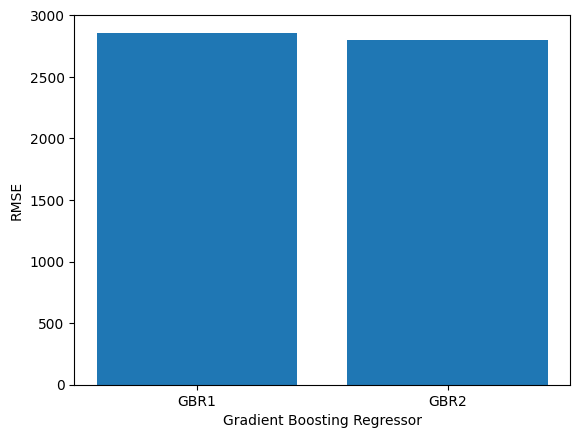

In [414]:
D = {'GBR1':2858.750227575626,'GBR2':2797.4144812840773}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE')
plt.xlabel('Gradient Boosting Regressor')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

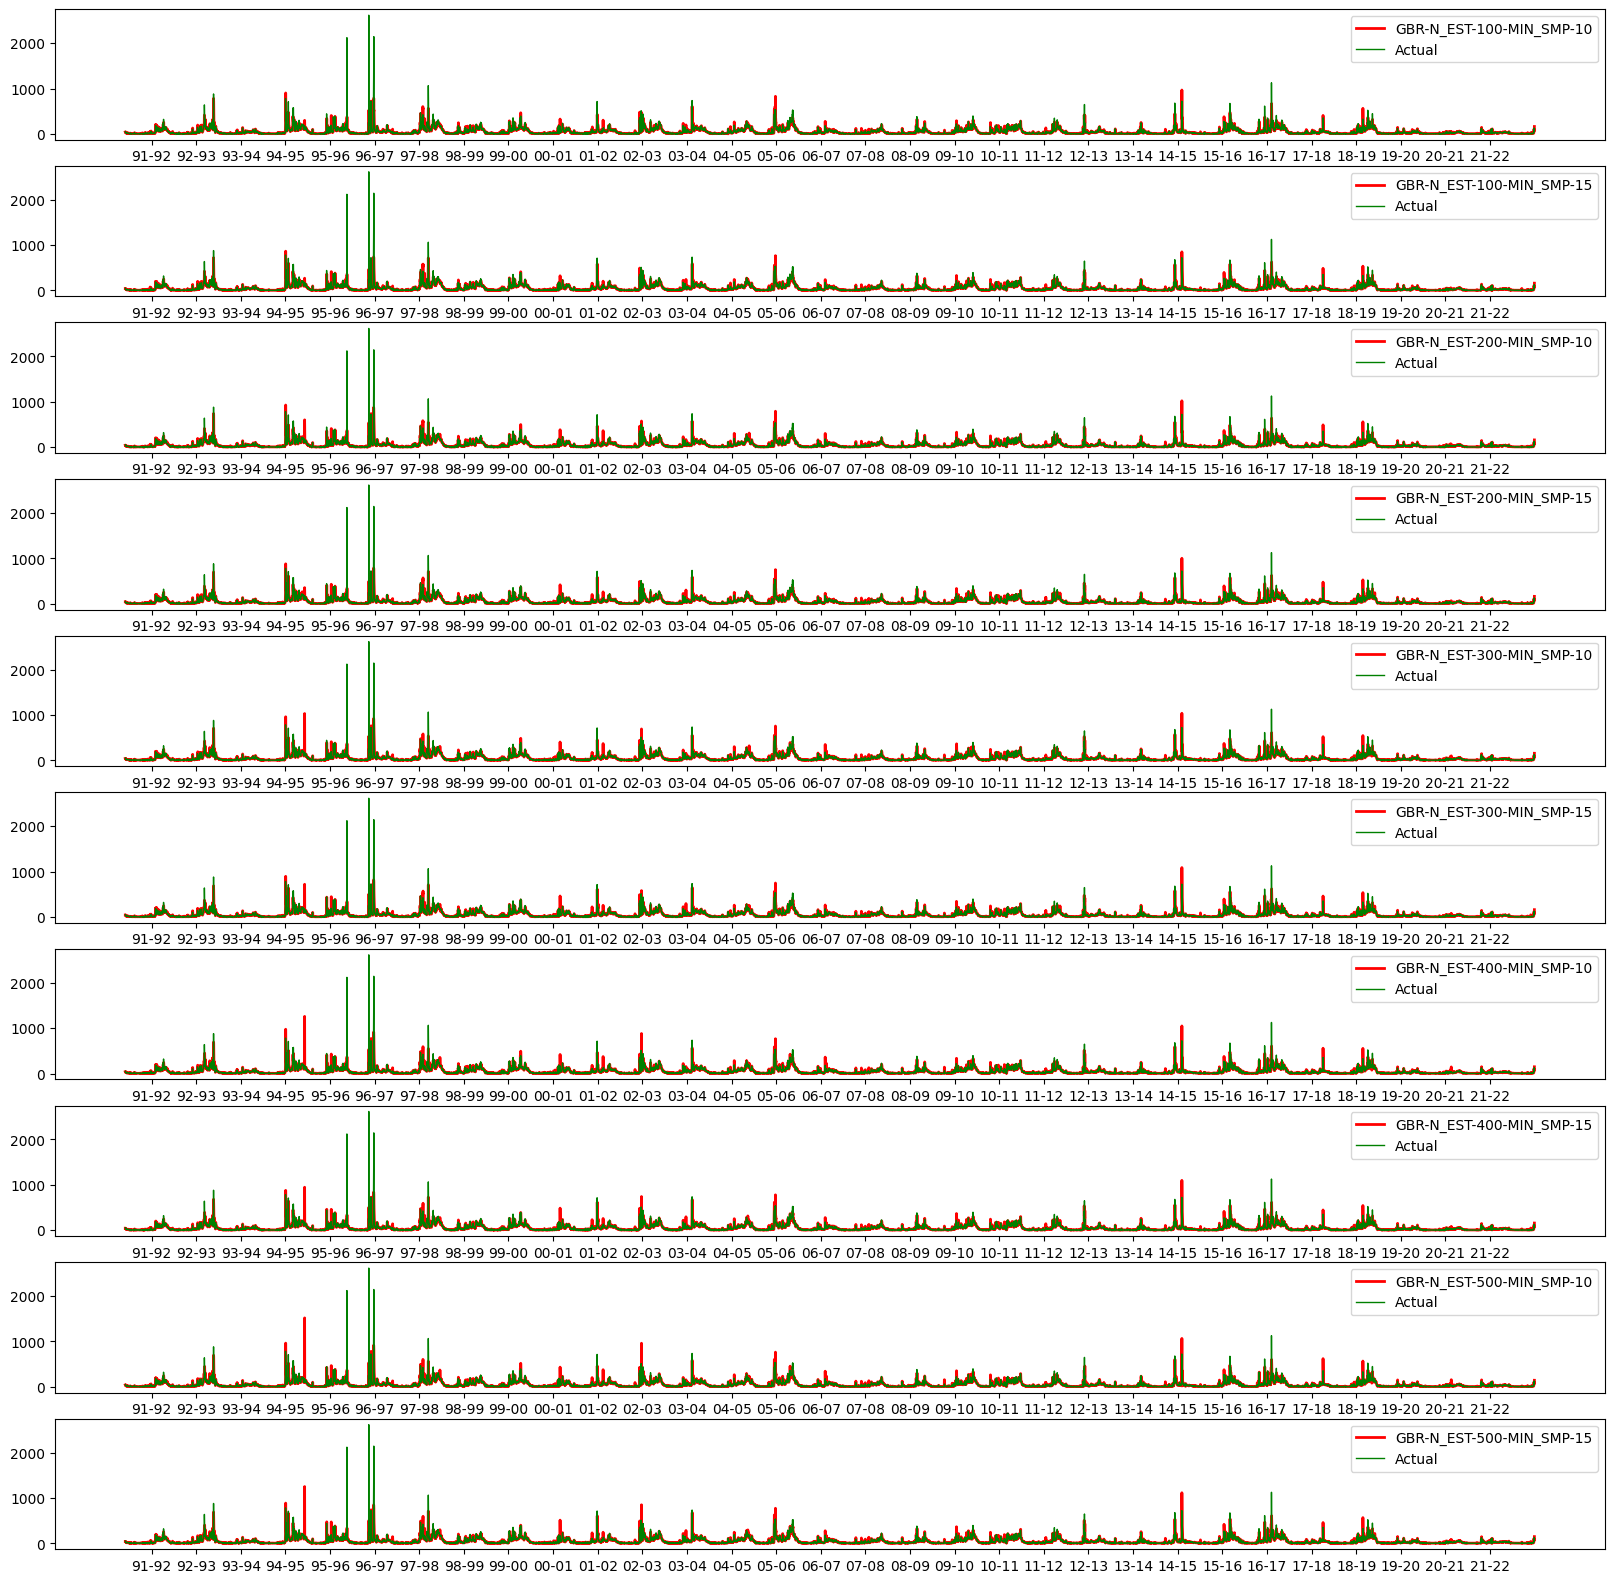

In [415]:
fig,ax = plt.subplots(10,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,11318,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
ax[0].plot(p_gbr_100_10,"red",label='GBR-N_EST-100-MIN_SMP-10',linewidth=2.0)
ax[0].plot(r_gbr_100_10,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_gbr_100_15,"red",label='GBR-N_EST-100-MIN_SMP-15',linewidth=2.0)
ax[1].plot(r_gbr_100_15,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_gbr_200_10,"red",label='GBR-N_EST-200-MIN_SMP-10',linewidth=2.0)
ax[2].plot(r_gbr_200_10,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_gbr_200_15,"red",label='GBR-N_EST-200-MIN_SMP-15',linewidth=2.0)
ax[3].plot(r_gbr_200_15,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_gbr_300_10,"red",label='GBR-N_EST-300-MIN_SMP-10',linewidth=2.0)
ax[4].plot(r_gbr_300_10,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_gbr_300_15,"red",label='GBR-N_EST-300-MIN_SMP-15',linewidth=2.0)
ax[5].plot(r_gbr_300_15,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_gbr_400_10,"red",label='GBR-N_EST-400-MIN_SMP-10',linewidth=2.0)
ax[6].plot(r_gbr_400_10,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_gbr_400_15,"red",label='GBR-N_EST-400-MIN_SMP-15',linewidth=2.0)
ax[7].plot(r_gbr_400_15,"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_gbr_500_10,"red",label='GBR-N_EST-500-MIN_SMP-10',linewidth=2.0)
ax[8].plot(r_gbr_500_10,"green",label='Actual',linewidth=1.0)
ax[8].legend()
ax[9].plot(p_gbr_500_15,"red",label='GBR-N_EST-500-MIN_SMP-15',linewidth=2.0)
ax[9].plot(r_gbr_500_15,"green",label='Actual',linewidth=1.0)
ax[9].legend()
plt.show()

##Final GBR

In [416]:
gbr = GradientBoostingRegressor(n_estimators=500,min_samples_leaf=15)
kf = KFold(n_splits=15, shuffle=False)
gbr_5_rmse = []
gbr_5_ns = []
gbr_5_kge = []
gbr_5_corr = []
predictions_gbr = []
real_gbr = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    y_train= np.array(y_train).ravel()
    gbr.fit(X_train, y_train)
    y_list_pred = list(gbr.predict(X_test))
    y_pred = np.array(y_list_pred)
    y_list_real = list(y_test['VALUE'])
    y_real = np.array(y_list_real)
    predictions_gbr.extend(y_list_pred)
    real_gbr.extend(y_list_real)
    gbr_5_rmse.append(math.sqrt(mean_squared_error(y_pred, y_real)))
    gbr_5_ns.append(NS(y_real,y_pred))
    gbr_5_kge.append(KGE(y_real,y_pred))
    gbr_5_corr.append(correlation(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


**Daily Accuracy**

In [417]:
print('RMSE ',mean(gbr_5_rmse))
print('NS ',mean(gbr_5_ns))
print('KGE ',mean(gbr_5_kge))
print('CORR ',mean(gbr_5_corr))

RMSE  38.01290687272969
NS  0.5920865606634459
KGE  0.7858892688511544
CORR  0.8623748283375485


In [418]:
Variance = np.var(np.array(predictions_gbr))
SSE = np.mean((np.mean(np.array(predictions_gbr)) - np.array(real_gbr))** 2)
Bias = SSE - Variance
print('Bias ', Bias)
print('Variance ',Variance)

Bias  1797.5211223741317
Variance  4747.57904693239


**Monthly Accuracy**

In [419]:
a = predictions_gbr[24:-4]
b = real_gbr[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
print('Monthly NS ',NS(np.array(r),np.array(p)))
print('Monthly KGE ',KGE(np.array(r),np.array(p)))
print('Monthly CORR ',correlation(np.array(r),np.array(p)))

Monthly RMSE  9.416174169690425
Monthly NS  0.9670297824974388
Monthly KGE  0.9278691584356422
Monthly CORR  0.9869556851221164


In [420]:
Variance = np.var(np.array(p))
SSE = np.mean((np.mean(np.array(p)) - np.array(r))** 2)
Bias = SSE - Variance
print('Bias ', Bias)
print('Variance ',Variance)

Bias  394.8289105272188
Variance  2689.2250858538437


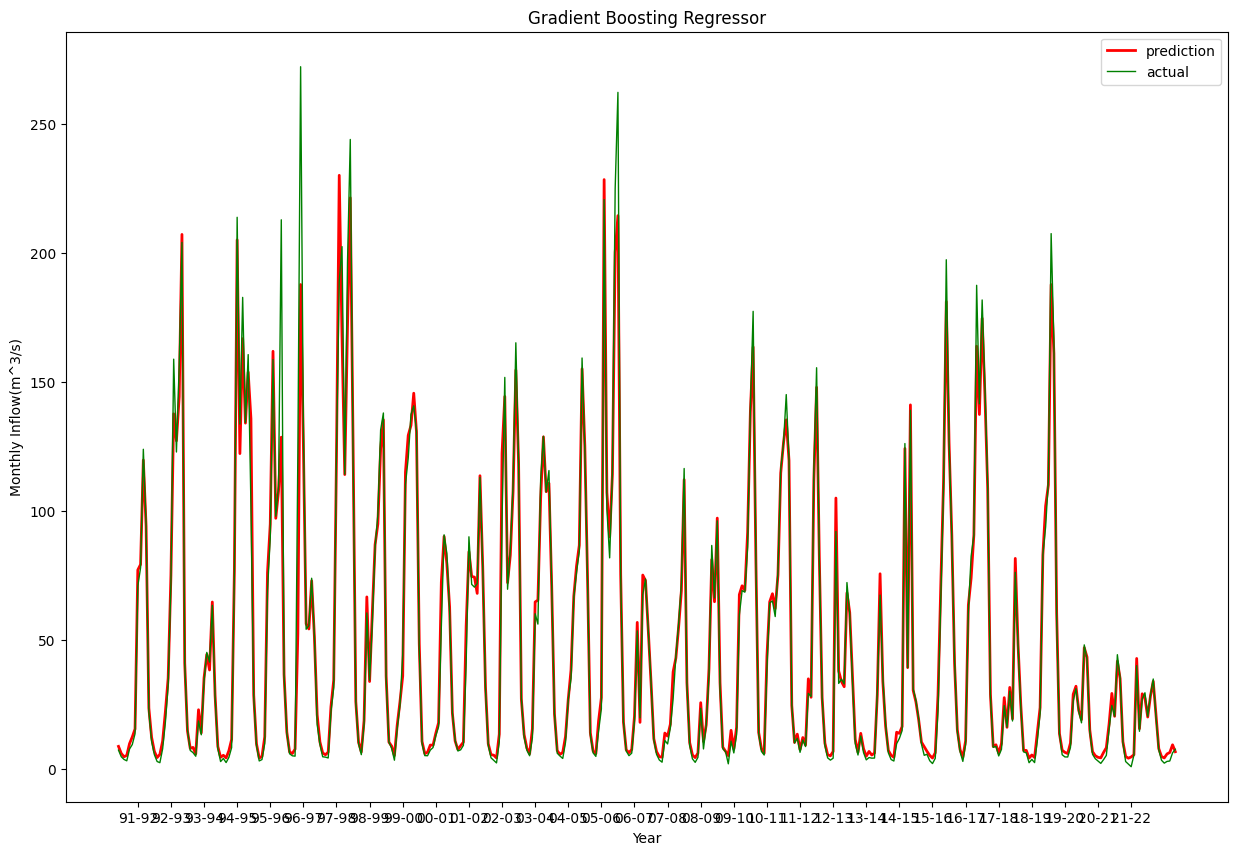

In [421]:
a = predictions_gbr[24:-4]
b = real_gbr[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,374,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("Gradient Boosting Regressor")
plt.show()

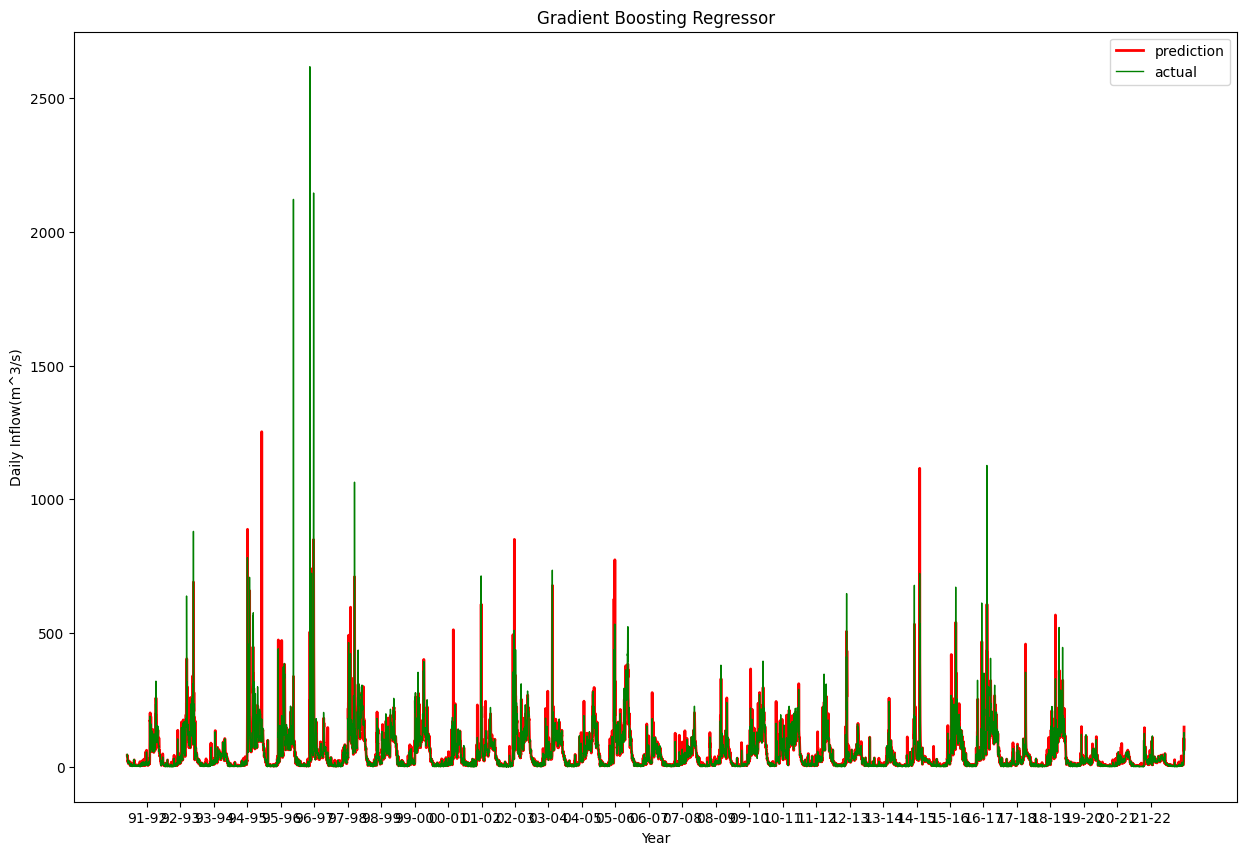

In [422]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_gbr, "red", label="prediction", linewidth=2.0)
plt.plot(real_gbr, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,11318,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("Gradient Boosting Regressor")
plt.show()

##KNN Regressor

In [423]:
from sklearn.neighbors import KNeighborsRegressor

In [424]:
knn_rmse = {}
knn_corr = {}
knn_r2 = {}
knn_mae = {}
knn_apb = {}
p_knn = {}
r_knn = {}
for i in range(55, 73, 2):
  num_neighbours = str(i)
  p_knn[num_neighbours] = []
  r_knn[num_neighbours] = []
  knn_rmse[num_neighbours] = []
  knn_corr[num_neighbours] = []
  knn_r2[num_neighbours] = []
  knn_mae[num_neighbours] = []
  knn_apb[num_neighbours] = []

  knn = KNeighborsRegressor(n_neighbors=i)
  kf = KFold(n_splits=15, shuffle=False)
  for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
      X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
      knn.fit(X_train, y_train)
      y_list = knn.predict(X_test)
      y_real = []
      y_pred = []
      for j in y_test['VALUE']:
        y_real.append(j)
      for j in y_list:
        y_pred.append(j)
      num_neighbours = str(i)
      p_knn[num_neighbours].extend(y_pred)
      r_knn[num_neighbours].extend(y_real)
      y_pred = np.array(y_pred).reshape(len(y_pred))
      y_real = np.array(y_real)
      knn_rmse[num_neighbours].append(math.sqrt(mean_squared_error(y_real, y_pred)))
      knn_corr[num_neighbours].append(correlation(y_real,y_pred))
      knn_r2[num_neighbours].append(r2_score(y_real,y_pred))
      knn_mae[num_neighbours].append(mean_absolute_error(y_real,y_pred))
      knn_apb[num_neighbours].append(Absolute_Percentage_Error(y_real,y_pred))
  knn_rmse[num_neighbours] = mean(knn_rmse[num_neighbours])
  knn_corr[num_neighbours] = mean(knn_corr[num_neighbours])
  knn_r2[num_neighbours] = mean(knn_r2[num_neighbours])
  knn_mae[num_neighbours] = mean(knn_mae[num_neighbours])
  knn_apb[num_neighbours] = mean(knn_apb[num_neighbours])
  

k-fold: 100%|██████████| 15/15 [00:00<00:00, 68.12it/s]


In [425]:
df = pd.DataFrame({'RMSE': knn_rmse, 'CORR': knn_corr, 'R2': knn_r2, 'MAE': knn_mae, 'APB': knn_apb})
df

RMSE      CORR        R2        MAE        APB
55  36.512067  0.871660  0.749174  12.097178  25.837293
57  36.570807  0.871186  0.748044  12.099932  25.842303
59  36.610848  0.870969  0.747439  12.115372  25.863833
61  36.727368  0.870088  0.745670  12.131898  25.906832
63  36.802850  0.869599  0.744940  12.141071  25.930829
65  36.828145  0.869142  0.743330  12.138722  25.951559
67  36.898661  0.868546  0.742596  12.150859  25.992932
69  36.968611  0.868114  0.741358  12.159930  26.026118
71  36.997812  0.868080  0.741418  12.164350  26.043586

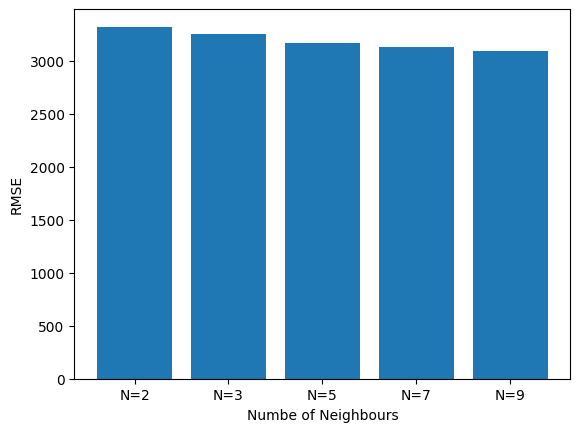

In [426]:
D = {'N=2':3322.518623791772,'N=3':3256.6557735051415,'N=5':3171.1417554308155,'N=7':3126.4909091631816,'N=9':3095.803650314192}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE')
plt.xlabel('Numbe of Neighbours')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

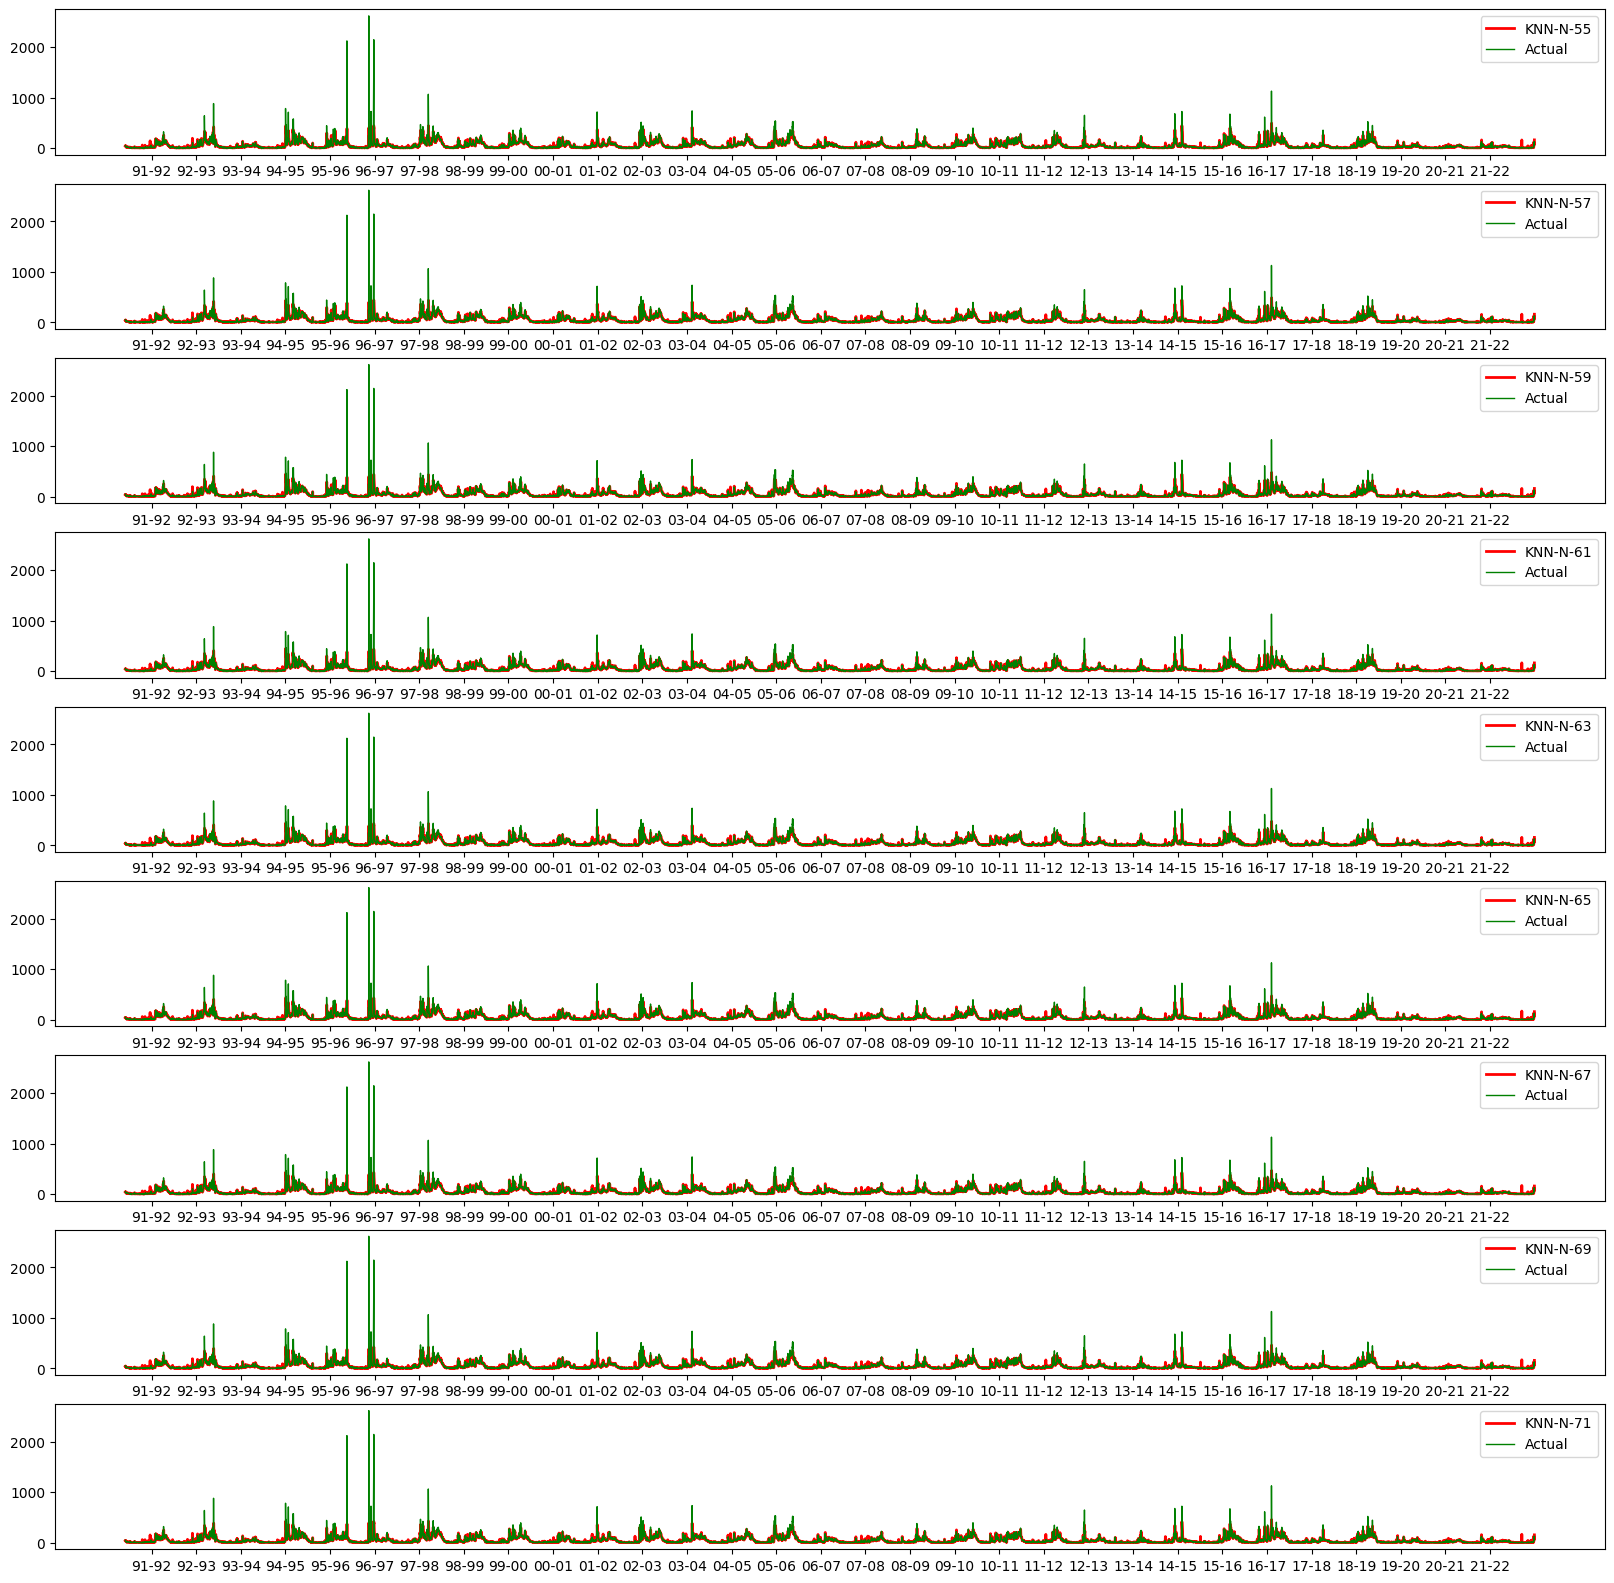

In [427]:
fig,ax = plt.subplots(9,1,figsize=(20,20))
plt.setp(ax, xticks=np.arange(215,11318,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
ax[0].plot(p_knn['55'],"red",label='KNN-N-55',linewidth=2.0)
ax[0].plot(r_knn['55'],"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_knn['57'],"red",label='KNN-N-57',linewidth=2.0)
ax[1].plot(r_knn['57'],"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_knn['59'],"red",label='KNN-N-59',linewidth=2.0)
ax[2].plot(r_knn['59'],"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_knn['61'],"red",label='KNN-N-61',linewidth=2.0)
ax[3].plot(r_knn['61'],"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_knn['63'],"red",label='KNN-N-63',linewidth=2.0)
ax[4].plot(r_knn['63'],"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_knn['65'],"red",label='KNN-N-65',linewidth=2.0)
ax[5].plot(r_knn['65'],"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_knn['67'],"red",label='KNN-N-67',linewidth=2.0)
ax[6].plot(r_knn['67'],"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_knn['69'],"red",label='KNN-N-69',linewidth=2.0)
ax[7].plot(r_knn['69'],"green",label='Actual',linewidth=1.0)
ax[7].legend()
ax[8].plot(p_knn['71'],"red",label='KNN-N-71',linewidth=2.0)
ax[8].plot(r_knn['71'],"green",label='Actual',linewidth=1.0)
ax[8].legend()
plt.show()

##Final KNN

In [428]:
knn = KNeighborsRegressor(n_neighbors=57)
kf = KFold(n_splits=15, shuffle=False)
knn_9_rmse = []
knn_9_ns = []
knn_9_corr = []
knn_9_kge = []
knn_9_r2score = []
knn_9_mae = []
predictions_knn = []
real_knn = []
for train_index, test_index in tqdm(kf.split(X_pca),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train, y_train)
    y_list = knn.predict(X_test)
    y_real = []
    y_pred = []
    for i in y_test['VALUE']:
      y_real.append(i)
    for i in y_list:
      y_pred.append(i)
    y_pred = np.array(y_pred).reshape(len(y_pred))
    predictions_knn.extend(y_list)
    real_knn.extend(y_real)
    y_real = np.array(y_real)
    knn_9_rmse.append(math.sqrt(mean_squared_error(y_real, y_pred)))
    knn_9_ns.append(NS(y_real,y_pred))
    knn_9_kge.append(KGE(y_real,y_pred))
    knn_9_corr.append(correlation(y_real,y_pred))
    knn_9_r2score.append(r2_score(y_real,y_pred))
    knn_9_mae.append(mean_absolute_error(y_real,y_pred))

k-fold: 100%|██████████| 15/15 [00:00<00:00, 76.85it/s]


**Daily Accuracy**

In [429]:
print('RMSE ',mean(knn_9_rmse))
# print('NS ',mean(knn_9_ns))
# print('KGE ',mean(knn_9_kge))
print('CORR ',mean(knn_9_corr))
print('R2 Score ',mean(knn_9_r2score))
print('MAE ',mean(knn_9_mae))

RMSE  36.57080736410051
CORR  0.8711863837042961
R2 Score  0.7480441521677795
MAE  12.099932020603905


**Monthly Accuracy**

In [430]:
a = predictions_knn[24:-4]
b = real_knn[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
# print('Monthly NS ',NS(np.array(r),np.array(p).reshape(len(p))))
# print('Monthly KGE ',KGE(np.array(r),np.array(p).reshape(len(p))))
print('Monthly CORR ',correlation(np.array(r),np.array(p).reshape(len(p))))
print('Monthly R2Score ',r2_score(r,p))
print('Monthly MAE', mean_absolute_error(r,p))

Monthly RMSE  11.237791892041885
Monthly CORR  0.9846931605847238
Monthly R2Score  0.959051089881944
Monthly MAE 4.279778768480385


**Monthly**

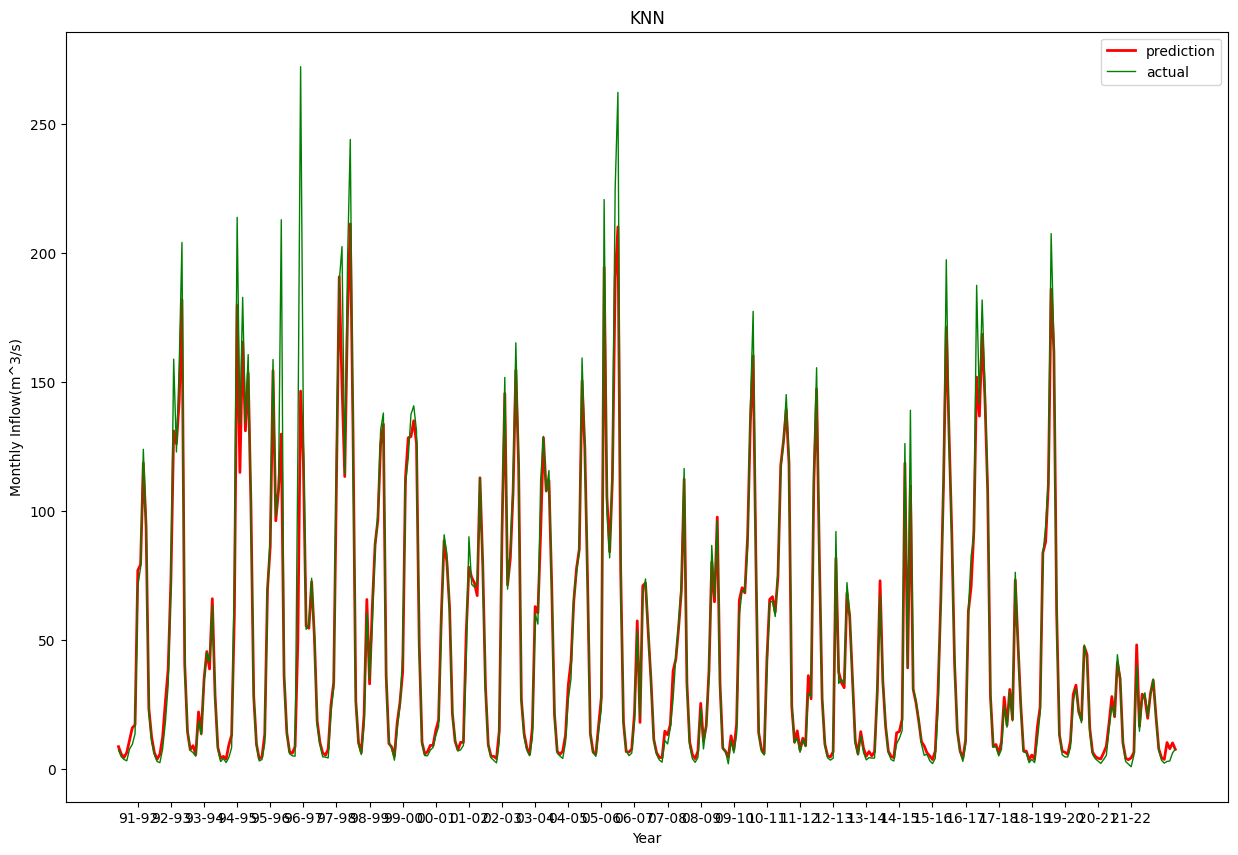

In [431]:
a = predictions_knn[24:-4]
b = real_knn[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,374,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("KNN")
plt.show()

**Daily**

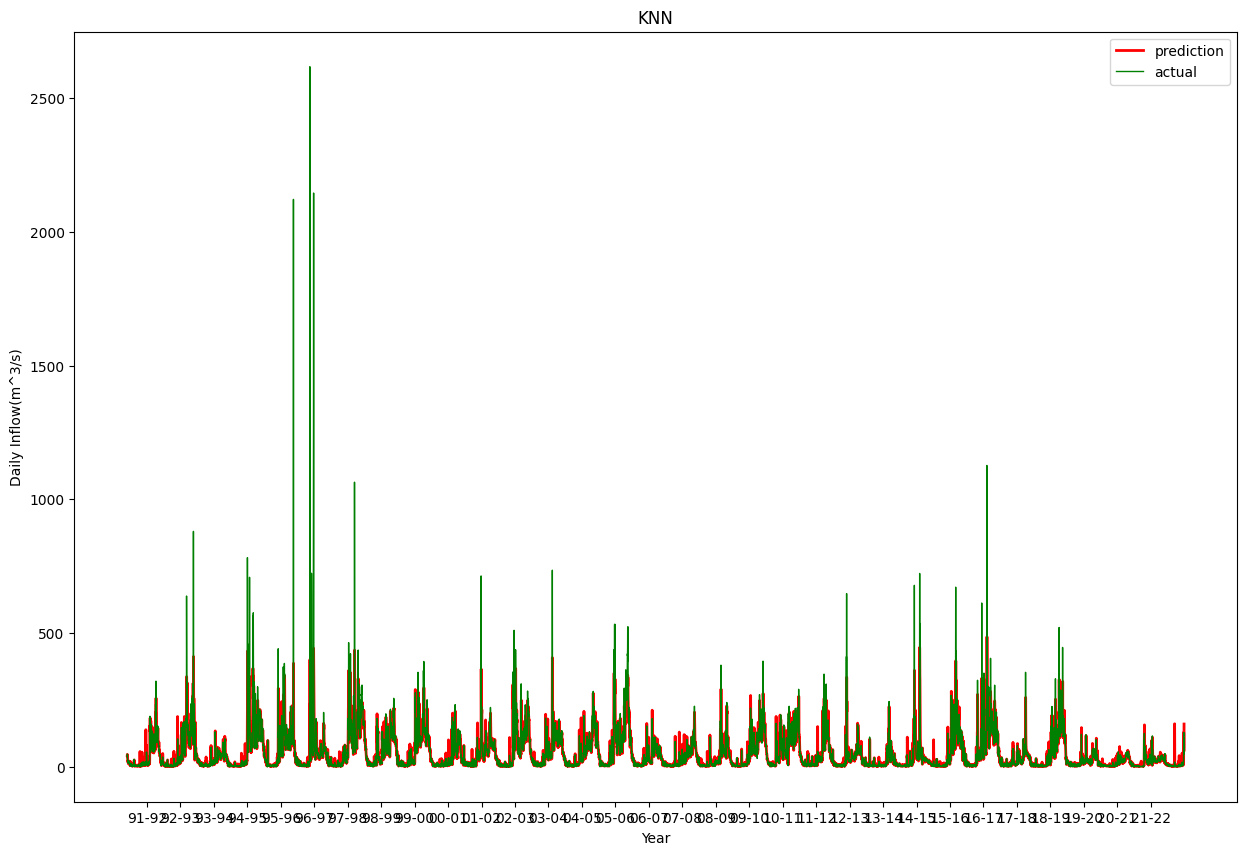

In [432]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_knn, "red", label="prediction", linewidth=2.0)
plt.plot(real_knn, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,11318,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("KNN")
plt.show()

##LSTM

In [433]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [434]:
x_lstm = X_pca.reshape(X_pca.shape[0],1,X_pca.shape[1])

In [435]:
# check if its running on gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17382069042630110853
xla_global_id: -1
]


**Epochs = 30**

In [436]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_30_rmse = []
score_30_corr = []
score_30_r2 = []
score_30_mae = []
score_30_apb = []
r_lstm_1 = []
p_lstm_1 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_1.extend(list(y_test['VALUE']))
    p_lstm_1.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_30_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_30_corr.append(correlation(y_test,yhat))
    score_30_r2.append(r2_score(y_test,yhat))
    score_30_mae.append(mean_absolute_error(y_test,yhat))
    score_30_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold:   0%|          | 0/15 [06:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
lstm_30 = pd.DataFrame({'actual':r_lstm_1,'predict':p_lstm_1})
lstm_30.to_csv('lstm_30.csv')

In [ ]:
print('RMSE ',mean(score_30_rmse))
print('CORR ',mean(score_30_corr))
print('R2 ',mean(score_30_r2))
print('MAE ',mean(score_30_mae))
print('APB ',mean(score_30_apb))

RMSE  16.98770514959119
CORR  0.9747543876353446
R2  0.9415684274280823
MAE  6.968245696235301
APB  14.140742962694597


**N=40**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_40_rmse = []
score_40_corr = []
score_40_r2 = []
score_40_mae = []
score_40_apb = []
r_lstm_2 = []
p_lstm_2 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_2.extend(list(y_test['VALUE']))
    p_lstm_2.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_40_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_40_corr.append(correlation(y_test,yhat))
    score_40_r2.append(r2_score(y_test,yhat))
    score_40_mae.append(mean_absolute_error(y_test,yhat))
    score_40_apb.append(Absolute_Percentage_Error(y_test,yhat))

k-fold:   0%|          | 0/15 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


k-fold:   7%|▋         | 1/15 [06:24<1:29:46, 384.77s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  13%|█▎        | 2/15 [10:46<1:07:44, 312.64s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  20%|██        | 3/15 [16:09<1:03:23, 316.97s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  27%|██▋       | 4/15 [19:31<49:47, 271.62s/it]  

25/25 [==============================] - 0s 3ms/step


k-fold:  33%|███▎      | 5/15 [24:48<48:00, 288.09s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  40%|████      | 6/15 [28:10<38:49, 258.86s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  47%|████▋     | 7/15 [31:32<32:02, 240.31s/it]

25/25 [==============================] - 0s 3ms/step


k-fold:  53%|█████▎    | 8/15 [34:49<26:24, 226.34s/it]

25/25 [==============================] - 0s 4ms/step


k-fold:  60%|██████    | 9/15 [37:11<20:00, 200.03s/it]

24/24 [==============================] - 0s 3ms/step


k-fold:  67%|██████▋   | 10/15 [39:48<15:33, 186.76s/it]

24/24 [==============================] - 0s 3ms/step


k-fold:  73%|███████▎  | 11/15 [44:10<13:59, 209.82s/it]

24/24 [==============================] - 0s 4ms/step


k-fold:  80%|████████  | 12/15 [46:32<09:27, 189.23s/it]

24/24 [==============================] - 0s 3ms/step


k-fold:  87%|████████▋ | 13/15 [48:54<05:49, 174.96s/it]

24/24 [==============================] - 0s 3ms/step


k-fold:  93%|█████████▎| 14/15 [51:16<02:45, 165.05s/it]

24/24 [==============================] - 0s 3ms/step


k-fold: 100%|██████████| 15/15 [53:38<00:00, 214.60s/it]


In [ ]:
lstm_40 = pd.DataFrame({'actual':r_lstm_2,'predict':p_lstm_2})
lstm_40.to_csv('lstm_40.csv')

In [ ]:
print('RMSE ',mean(score_40_rmse))
print('CORR ',mean(score_40_corr))
print('R2 ',mean(score_40_r2))
print('MAE ',mean(score_40_mae))
print('APB ',mean(score_40_apb))

RMSE  16.80150289830478
CORR  0.973316829546464
R2  0.9405186709193407
MAE  6.367428082774968
APB  12.597791698061831


**Epochs = 50**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_50_rmse = []
score_50_corr = []
score_50_r2 = []
score_50_mae = []
score_50_apb =[]
r_lstm_3 = []
p_lstm_3 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_3.extend(list(y_test['VALUE']))
    p_lstm_3.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_50_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_50_corr.append(correlation(y_test,yhat))
    score_50_r2.append(r2_score(y_test,yhat))
    score_50_mae.append(mean_absolute_error(y_test,yhat))
    score_50_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_50 = pd.DataFrame({'actual':r_lstm_3,'predict':p_lstm_3})
lstm_50.to_csv('lstm_50.csv')

In [ ]:
print('RMSE ',mean(score_50_rmse))
print('CORR ',mean(score_50_corr))
print('R2 ',mean(score_50_r2))
print('MAE ',mean(score_50_mae))
print('APB ',mean(score_50_apb))

**N=60**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_60_rmse = []
score_60_corr = []
score_60_r2 = []
score_60_mae = []
score_60_apb = []
r_lstm_4 = []
p_lstm_4 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=60, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_4.extend(list(y_test['VALUE']))
    p_lstm_4.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_60_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_60_corr.append(correlation(y_test,yhat))
    score_60_r2.append(r2_score(y_test,yhat))
    score_60_mae.append(mean_absolute_error(y_test,yhat))
    score_60_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_60 = pd.DataFrame({'actual':r_lstm_4,'predict':p_lstm_4})
lstm_60.to_csv('lstm_60.csv')

In [ ]:
print('RMSE ',mean(score_60_rmse))
print('CORR ',mean(score_60_corr))
print('R2 ',mean(score_60_r2))
print('MAE ',mean(score_60_mae))
print('APB ',mean(score_60_apb))

**Epoch = 70**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_70_rmse = []
score_70_corr = []
score_70_r2 = []
score_70_mae = []
score_70_apb = []
r_lstm_5 = []
p_lstm_5 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_5.extend(list(y_test['VALUE']))
    p_lstm_5.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_70_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_70_corr.append(correlation(y_test,yhat))
    score_70_r2.append(r2_score(y_test,yhat))
    score_70_mae.append(mean_absolute_error(y_test,yhat))
    score_70_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_70 = pd.DataFrame({'actual':r_lstm_5,'predict':p_lstm_5})
lstm_70.to_csv('lstm_70.csv')

In [ ]:
print('RMSE ',mean(score_70_rmse))
print('CORR ',mean(score_70_corr))
print('R2 ',mean(score_70_r2))
print('MAE ',mean(score_70_mae))
print('APB ',mean(score_70_apb))

**N=80**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_80_rmse = []
score_80_corr = []
score_80_r2 = []
score_80_mae = []
score_80_apb = []
r_lstm_6 = []
p_lstm_6 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_6.extend(list(y_test['VALUE']))
    p_lstm_6.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_80_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_80_corr.append(correlation(y_test,yhat))
    score_80_r2.append(r2_score(y_test,yhat))
    score_80_mae.append(mean_absolute_error(y_test,yhat))
    score_80_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_80 = pd.DataFrame({'actual':r_lstm_6,'predict':p_lstm_6})
lstm_80.to_csv('lstm_80.csv')

In [ ]:
print('RMSE ',mean(score_80_rmse))
print('CORR ',mean(score_80_corr))
print('R2 ',mean(score_80_r2))
print('MAE ',mean(score_80_mae))
print('APB ',mean(score_80_apb))

**N=90**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_90_rmse = []
score_90_corr = []
score_90_r2 = []
score_90_mae = []
score_90_apb = []
r_lstm_7 = []
p_lstm_7 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=90, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_7.extend(list(y_test['VALUE']))
    p_lstm_7.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_90_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_90_corr.append(correlation(y_test,yhat))
    score_90_r2.append(r2_score(y_test,yhat))
    score_90_mae.append(mean_absolute_error(y_test,yhat))
    score_90_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_90 = pd.DataFrame({'actual':r_lstm_7,'predict':p_lstm_7})
lstm_90.to_csv('lstm_90.csv')

In [ ]:
print('RMSE ',mean(score_90_rmse))
print('CORR ',mean(score_90_corr))
print('R2 ',mean(score_90_r2))
print('MAE ',mean(score_90_mae))
print('APB ',mean(score_90_apb))

**Epoch = 100**

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_100_rmse = []
score_100_corr = []
score_100_r2 = []
score_100_mae = []
score_100_apb = []
r_lstm_8 = []
p_lstm_8 = []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False,verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      if i[0][0] < 0:
        yhat.append(0)
      else:
        yhat.append(i[0][0])
    r_lstm_8.extend(list(y_test['VALUE']))
    p_lstm_8.extend(yhat)
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_100_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_100_corr.append(correlation(y_test,yhat))
    score_100_r2.append(r2_score(y_test,yhat))
    score_100_mae.append(mean_absolute_error(y_test,yhat))
    score_100_apb.append(Absolute_Percentage_Error(y_test,yhat))

In [ ]:
lstm_100 = pd.DataFrame({'actual':r_lstm_8,'predict':p_lstm_8})
lstm_100.to_csv('lstm_100.csv')

In [ ]:
print('RMSE ',mean(score_100_rmse))
print('CORR ',mean(score_100_corr))
print('R2 ',mean(score_100_r2))
print('MAE ',mean(score_100_mae))
print('APB ',mean(score_100_apb))

In [ ]:
D = {'LSTM1':543.9768419315196,'LSTM2':456.5707681714717,'LSTM3':292.1108931957561,'LSTM4':339.3957034619337}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('LSTM')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

In [ ]:
fig,ax = plt.subplots(8,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(215,5488,step=365),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
ax[0].plot(p_lstm_1,"red",label='LSTM-EPOCH-30',linewidth=2.0)
ax[0].plot(r_lstm_1,"green",label='Actual',linewidth=1.0)
ax[0].legend()
ax[1].plot(p_lstm_2,"red",label='LSTM-EPOCH-40',linewidth=2.0)
ax[1].plot(r_lstm_2,"green",label='Actual',linewidth=1.0)
ax[1].legend()
ax[2].plot(p_lstm_3,"red",label='LSTM-EPOCH-50',linewidth=2.0)
ax[2].plot(r_lstm_3,"green",label='Actual',linewidth=1.0)
ax[2].legend()
ax[3].plot(p_lstm_4,"red",label='LSTM-EPOCH-60',linewidth=2.0)
ax[3].plot(r_lstm_4,"green",label='Actual',linewidth=1.0)
ax[3].legend()
ax[4].plot(p_lstm_5,"red",label='LSTM-EPOCH-70',linewidth=2.0)
ax[4].plot(r_lstm_5,"green",label='Actual',linewidth=1.0)
ax[4].legend()
ax[5].plot(p_lstm_6,"red",label='LSTM-EPOCH-80',linewidth=2.0)
ax[5].plot(r_lstm_6,"green",label='Actual',linewidth=1.0)
ax[5].legend()
ax[6].plot(p_lstm_7,"red",label='LSTM-EPOCH-90',linewidth=2.0)
ax[6].plot(r_lstm_7,"green",label='Actual',linewidth=1.0)
ax[6].legend()
ax[7].plot(p_lstm_8,"red",label='LSTM-EPOCH-100',linewidth=2.0)
ax[7].plot(r_lstm_8,"green",label='Actual',linewidth=1.0)
ax[7].legend()
plt.show()

##Final LSTM

In [ ]:
stop_noimprovement = EarlyStopping(monitor='loss', patience=10)
model = Sequential()
model.add(LSTM(units=1024, activation='relu',return_sequences=True, input_shape=(1, x_lstm.shape[2])))
model.add(LSTM(units=1024,activation='relu', return_sequences=True))
model.add(Dense(units=1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

kf = KFold(n_splits=15, shuffle=False)
score_90_rmse = []
score_90_corr = []
score_90_r2 = []
score_90_mae = []
predictions_lstm = []
real_lstm= []
for train_index, test_index in tqdm(kf.split(x_lstm),total=kf.get_n_splits(),desc="k-fold"):
    X_train, X_test, y_train, y_test = x_lstm[train_index], x_lstm[test_index], y.iloc[train_index], y.iloc[test_index]
    lstm_history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_noimprovement], shuffle=False, verbose=False)
    yht = model.predict(X_test)
    yhat= []
    for i in yht:
      yhat.append(i[0][0])
    predictions_lstm.extend(yhat)
    real_lstm.extend(list(y_test['VALUE']))
    yhat = np.array(yhat)
    y_test = np.array(list(y_test['VALUE']))
    score_90_rmse.append(math.sqrt(mean_squared_error(y_test, yhat)))
    score_90_corr.append(correlation(y_test,yhat))
    score_90_r2.append(r2_score(y_test,yhat))
    score_90_mae.append(mean_absolute_error(y_test,yhat))

**Daily Accuracy**

In [ ]:
print('RMSE ',mean(score_90_rmse))
print('CORR ',mean(score_90_corr))
print('R2 ',mean(score_90_r2))
print('MAE ',mean(score_90_mae))

**Monthly Accuracy**

In [ ]:
a = predictions_lstm[24:-4]
b = real_lstm[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
print('Monthly RMSE ',math.sqrt(mean_squared_error(p, r)))
print('Monthly CORR ',correlation(np.array(p),np.array(r)))
print('Monthly R2 ',r2_score(p,r))
print('Monthly MAE ',mean_absolute_error(p,r))

**Monthly**

In [ ]:
a = predictions_lstm[24:-4]
b = real_lstm[24:-4]
i = 0
p = []
r = []
while i < len(a):
  t = a[i:i+30]
  avg = sum(t)/30
  p.append(avg)
  t = b[i:i+30]
  avg = sum(t)/30
  r.append(avg)
  i = i+30
plt.figure(figsize=(15, 10))
plt.plot(p, "red", label="prediction", linewidth=2.0)
plt.plot(r, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Monthly Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(7,182,step=12),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("LSTM")
plt.show()

**Daily**

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(predictions_lstm, "red", label="prediction", linewidth=2.0)
plt.plot(real_lstm, 'green', label="actual", linewidth=1.0)
plt.legend()
plt.ylabel('Daily Inflow(m^3/s)')
plt.xlabel('Year')
plt.xticks(np.arange(215,5488,step=365),['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22'])
plt.title("LSTM")
plt.show()

##Overall Comparison

In [ ]:
D = {'KNN':3095.803650314192,'RF':2839.750828563568,'GBR':2775.260003572779,'LSTM':302.45617875012897}
plt.bar(range(len(D)), list(D.values()), align='center')
plt.ylabel('RMSE(m^3/s)')
plt.xlabel('Algorithms')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

##Experiments

In [ ]:
gbr_100_10 = pd.read_csv('/content/data/gbr_100_10.csv')
gbr_100_15 = pd.read_csv('/content/data/gbr_100_15.csv')
gbr_200_10 = pd.read_csv('/content/data/gbr_200_10.csv')
gbr_200_15 = pd.read_csv('/content/data/gbr_200_15.csv')
gbr_300_10 = pd.read_csv('/content/data/gbr_300_10.csv')
gbr_300_15 = pd.read_csv('/content/data/gbr_300_15.csv')
gbr_400_10 = pd.read_csv('/content/data/gbr_400_10.csv')
gbr_400_15 = pd.read_csv('/content/data/gbr_400_15.csv')
gbr_500_10 = pd.read_csv('/content/data/gbr_500_10.csv')
gbr_500_15 = pd.read_csv('/content/data/gbr_500_15.csv')
knn_55 = pd.read_csv('/content/data/knn_55.csv')
knn_57 = pd.read_csv('/content/data/knn_57.csv')
knn_59 = pd.read_csv('/content/data/knn_59.csv')
knn_61 = pd.read_csv('/content/data/knn_61.csv')
knn_63 = pd.read_csv('/content/data/knn_63.csv')
knn_65 = pd.read_csv('/content/data/knn_65.csv')
knn_67 = pd.read_csv('/content/data/knn_67.csv')
knn_69 = pd.read_csv('/content/data/knn_69.csv')
knn_71 = pd.read_csv('/content/data/knn_71.csv')
lstm_30 = pd.read_csv('/content/data/lstm_30.csv')
lstm_40 = pd.read_csv('/content/data/lstm_40.csv')
lstm_50 = pd.read_csv('/content/data/lstm_50.csv')
lstm_60 = pd.read_csv('/content/data/lstm_60.csv')
lstm_70 = pd.read_csv('/content/data/lstm_70.csv')
lstm_80 = pd.read_csv('/content/data/lstm_80.csv')
lstm_90 = pd.read_csv('/content/data/lstm_90.csv')
lstm_100 = pd.read_csv('/content/data/lstm_100.csv')
rf_500_29 = pd.read_csv('/content/data/rf_500_29.csv')
rf_500_31 = pd.read_csv('/content/data/rf_500_31.csv')
rf_600_29 = pd.read_csv('/content/data/rf_600_29.csv')
rf_600_31 = pd.read_csv('/content/data/rf_600_31.csv')
rf_700_29 = pd.read_csv('/content/data/rf_700_29.csv')
rf_700_31 = pd.read_csv('/content/data/rf_700_31.csv')
rf_800_29 = pd.read_csv('/content/data/rf_800_29.csv')
rf_800_31 = pd.read_csv('/content/data/rf_800_31.csv')
rf_900_29 = pd.read_csv('/content/data/rf_900_29.csv')
rf_900_31 = pd.read_csv('/content/data/rf_900_31.csv')
rf_1000_29 = pd.read_csv('/content/data/rf_1000_29.csv')
rf_1000_31 = pd.read_csv('/content/data/rf_1000_31.csv')

##Monthly Comparison

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

for i in range(0,5460,30):
  a_gbr_100_10.append(sum(list(gbr_100_10['actual'])[i:i+30]))
  p_gbr_100_10.append(sum(list(gbr_100_10['predict'])[i:i+30]))
a_gbr_100_10.append(sum(list(gbr_100_10['actual'])[5460:]))
p_gbr_100_10.append(sum(list(gbr_100_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_100_15.append(sum(list(gbr_100_15['actual'])[i:i+30]))
  p_gbr_100_15.append(sum(list(gbr_100_15['predict'])[i:i+30]))
a_gbr_100_15.append(sum(list(gbr_100_15['actual'])[5460:]))
p_gbr_100_15.append(sum(list(gbr_100_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_200_10.append(sum(list(gbr_200_10['actual'])[i:i+30]))
  p_gbr_200_10.append(sum(list(gbr_200_10['predict'])[i:i+30]))
a_gbr_200_10.append(sum(list(gbr_200_10['actual'])[5460:]))
p_gbr_200_10.append(sum(list(gbr_200_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_200_15.append(sum(list(gbr_200_15['actual'])[i:i+30]))
  p_gbr_200_15.append(sum(list(gbr_200_15['predict'])[i:i+30]))
a_gbr_200_15.append(sum(list(gbr_200_15['actual'])[5460:]))
p_gbr_200_15.append(sum(list(gbr_200_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_300_10.append(sum(list(gbr_300_10['actual'])[i:i+30]))
  p_gbr_300_10.append(sum(list(gbr_300_10['predict'])[i:i+30]))
a_gbr_300_10.append(sum(list(gbr_300_10['actual'])[5460:]))
p_gbr_300_10.append(sum(list(gbr_300_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_300_15.append(sum(list(gbr_300_15['actual'])[i:i+30]))
  p_gbr_300_15.append(sum(list(gbr_300_15['predict'])[i:i+30]))
a_gbr_300_15.append(sum(list(gbr_300_15['actual'])[5460:]))
p_gbr_300_15.append(sum(list(gbr_300_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_400_10.append(sum(list(gbr_400_10['actual'])[i:i+30]))
  p_gbr_400_10.append(sum(list(gbr_400_10['predict'])[i:i+30]))
a_gbr_400_10.append(sum(list(gbr_400_10['actual'])[5460:]))
p_gbr_400_10.append(sum(list(gbr_400_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_400_15.append(sum(list(gbr_400_15['actual'])[i:i+30]))
  p_gbr_400_15.append(sum(list(gbr_400_15['predict'])[i:i+30]))
a_gbr_400_15.append(sum(list(gbr_400_15['actual'])[5460:]))
p_gbr_400_15.append(sum(list(gbr_400_15['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_500_10.append(sum(list(gbr_500_10['actual'])[i:i+30]))
  p_gbr_500_10.append(sum(list(gbr_500_10['predict'])[i:i+30]))
a_gbr_500_10.append(sum(list(gbr_500_10['actual'])[5460:]))
p_gbr_500_10.append(sum(list(gbr_500_10['predict'])[5460:]))

for i in range(0,5460,30):
  a_gbr_500_15.append(sum(list(gbr_500_15['actual'])[i:i+30]))
  p_gbr_500_15.append(sum(list(gbr_500_15['predict'])[i:i+30]))
a_gbr_500_15.append(sum(list(gbr_500_15['actual'])[5460:]))
p_gbr_500_15.append(sum(list(gbr_500_15['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

for i in range(0,5460,30):
  a_knn_55.append(sum(list(knn_55['actual'])[i:i+30]))
  p_knn_55.append(sum(list(knn_55['predict'])[i:i+30]))
a_knn_55.append(sum(list(knn_55['actual'])[5460:]))
p_knn_55.append(sum(list(knn_55['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_57.append(sum(list(knn_57['actual'])[i:i+30]))
  p_knn_57.append(sum(list(knn_57['predict'])[i:i+30]))
a_knn_57.append(sum(list(knn_57['actual'])[5460:]))
p_knn_57.append(sum(list(knn_57['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_59.append(sum(list(knn_59['actual'])[i:i+30]))
  p_knn_59.append(sum(list(knn_59['predict'])[i:i+30]))
a_knn_59.append(sum(list(knn_59['actual'])[5460:]))
p_knn_59.append(sum(list(knn_59['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_61.append(sum(list(knn_61['actual'])[i:i+30]))
  p_knn_61.append(sum(list(knn_61['predict'])[i:i+30]))
a_knn_61.append(sum(list(knn_61['actual'])[5460:]))
p_knn_61.append(sum(list(knn_61['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_63.append(sum(list(knn_63['actual'])[i:i+30]))
  p_knn_63.append(sum(list(knn_63['predict'])[i:i+30]))
a_knn_63.append(sum(list(knn_63['actual'])[5460:]))
p_knn_63.append(sum(list(knn_63['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_65.append(sum(list(knn_65['actual'])[i:i+30]))
  p_knn_65.append(sum(list(knn_65['predict'])[i:i+30]))
a_knn_65.append(sum(list(knn_65['actual'])[5460:]))
p_knn_65.append(sum(list(knn_65['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_67.append(sum(list(knn_67['actual'])[i:i+30]))
  p_knn_67.append(sum(list(knn_67['predict'])[i:i+30]))
a_knn_67.append(sum(list(knn_67['actual'])[5460:]))
p_knn_67.append(sum(list(knn_67['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_69.append(sum(list(knn_69['actual'])[i:i+30]))
  p_knn_69.append(sum(list(knn_69['predict'])[i:i+30]))
a_knn_69.append(sum(list(knn_69['actual'])[5460:]))
p_knn_69.append(sum(list(knn_69['predict'])[5460:]))

for i in range(0,5460,30):
  a_knn_71.append(sum(list(knn_71['actual'])[i:i+30]))
  p_knn_71.append(sum(list(knn_71['predict'])[i:i+30]))
a_knn_71.append(sum(list(knn_71['actual'])[5460:]))
p_knn_71.append(sum(list(knn_71['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

for i in range(0,5460,30):
  a_lstm_30.append(sum(list(lstm_30['actual'])[i:i+30]))
  p_lstm_30.append(sum(list(lstm_30['predict'])[i:i+30]))
a_lstm_30.append(sum(list(lstm_30['actual'])[5460:]))
p_lstm_30.append(sum(list(lstm_30['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_40.append(sum(list(lstm_40['actual'])[i:i+30]))
  p_lstm_40.append(sum(list(lstm_40['predict'])[i:i+30]))
a_lstm_40.append(sum(list(lstm_40['actual'])[5460:]))
p_lstm_40.append(sum(list(lstm_40['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_50.append(sum(list(lstm_50['actual'])[i:i+30]))
  p_lstm_50.append(sum(list(lstm_50['predict'])[i:i+30]))
a_lstm_50.append(sum(list(lstm_50['actual'])[5460:]))
p_lstm_50.append(sum(list(lstm_50['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_60.append(sum(list(lstm_60['actual'])[i:i+30]))
  p_lstm_60.append(sum(list(lstm_60['predict'])[i:i+30]))
a_lstm_60.append(sum(list(lstm_60['actual'])[5460:]))
p_lstm_60.append(sum(list(lstm_60['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_70.append(sum(list(lstm_70['actual'])[i:i+30]))
  p_lstm_70.append(sum(list(lstm_70['predict'])[i:i+30]))
a_lstm_70.append(sum(list(lstm_70['actual'])[5460:]))
p_lstm_70.append(sum(list(lstm_70['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_80.append(sum(list(lstm_80['actual'])[i:i+30]))
  p_lstm_80.append(sum(list(lstm_80['predict'])[i:i+30]))
a_lstm_80.append(sum(list(lstm_80['actual'])[5460:]))
p_lstm_80.append(sum(list(lstm_80['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_90.append(sum(list(lstm_90['actual'])[i:i+30]))
  p_lstm_90.append(sum(list(lstm_90['predict'])[i:i+30]))
a_lstm_90.append(sum(list(lstm_90['actual'])[5460:]))
p_lstm_90.append(sum(list(lstm_90['predict'])[5460:]))

for i in range(0,5460,30):
  a_lstm_100.append(sum(list(lstm_100['actual'])[i:i+30]))
  p_lstm_100.append(sum(list(lstm_100['predict'])[i:i+30]))
a_lstm_100.append(sum(list(lstm_100['actual'])[5460:]))
p_lstm_100.append(sum(list(lstm_100['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

for i in range(0,5460,30):
  a_rf_500_29.append(sum(list(rf_500_29['actual'])[i:i+30]))
  p_rf_500_29.append(sum(list(rf_500_29['predict'])[i:i+30]))
a_rf_500_29.append(sum(list(rf_500_29['actual'])[5460:]))
p_rf_500_29.append(sum(list(rf_500_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_500_31.append(sum(list(rf_500_31['actual'])[i:i+30]))
  p_rf_500_31.append(sum(list(rf_500_31['predict'])[i:i+30]))
a_rf_500_31.append(sum(list(rf_500_31['actual'])[5460:]))
p_rf_500_31.append(sum(list(rf_500_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_600_29.append(sum(list(rf_600_29['actual'])[i:i+30]))
  p_rf_600_29.append(sum(list(rf_600_29['predict'])[i:i+30]))
a_rf_600_29.append(sum(list(rf_600_29['actual'])[5460:]))
p_rf_600_29.append(sum(list(rf_600_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_600_31.append(sum(list(rf_600_31['actual'])[i:i+30]))
  p_rf_600_31.append(sum(list(rf_600_31['predict'])[i:i+30]))
a_rf_600_31.append(sum(list(rf_600_31['actual'])[5460:]))
p_rf_600_31.append(sum(list(rf_600_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_700_29.append(sum(list(rf_700_29['actual'])[i:i+30]))
  p_rf_700_29.append(sum(list(rf_700_29['predict'])[i:i+30]))
a_rf_700_29.append(sum(list(rf_700_29['actual'])[5460:]))
p_rf_700_29.append(sum(list(rf_700_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_700_31.append(sum(list(rf_700_31['actual'])[i:i+30]))
  p_rf_700_31.append(sum(list(rf_700_31['predict'])[i:i+30]))
a_rf_700_31.append(sum(list(rf_700_31['actual'])[5460:]))
p_rf_700_31.append(sum(list(rf_700_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_800_29.append(sum(list(rf_800_29['actual'])[i:i+30]))
  p_rf_800_29.append(sum(list(rf_800_29['predict'])[i:i+30]))
a_rf_800_29.append(sum(list(rf_800_29['actual'])[5460:]))
p_rf_800_29.append(sum(list(rf_800_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_800_31.append(sum(list(rf_800_31['actual'])[i:i+30]))
  p_rf_800_31.append(sum(list(rf_800_31['predict'])[i:i+30]))
a_rf_800_31.append(sum(list(rf_800_31['actual'])[5460:]))
p_rf_800_31.append(sum(list(rf_800_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_900_29.append(sum(list(rf_900_29['actual'])[i:i+30]))
  p_rf_900_29.append(sum(list(rf_900_29['predict'])[i:i+30]))
a_rf_900_29.append(sum(list(rf_900_29['actual'])[5460:]))
p_rf_900_29.append(sum(list(rf_900_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_900_31.append(sum(list(rf_900_31['actual'])[i:i+30]))
  p_rf_900_31.append(sum(list(rf_900_31['predict'])[i:i+30]))
a_rf_900_31.append(sum(list(rf_900_31['actual'])[5460:]))
p_rf_900_31.append(sum(list(rf_900_31['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_1000_29.append(sum(list(rf_1000_29['actual'])[i:i+30]))
  p_rf_1000_29.append(sum(list(rf_1000_29['predict'])[i:i+30]))
a_rf_1000_29.append(sum(list(rf_1000_29['actual'])[5460:]))
p_rf_1000_29.append(sum(list(rf_1000_29['predict'])[5460:]))

for i in range(0,5460,30):
  a_rf_1000_31.append(sum(list(rf_1000_31['actual'])[i:i+30]))
  p_rf_1000_31.append(sum(list(rf_1000_31['predict'])[i:i+30]))
a_rf_1000_31.append(sum(list(rf_1000_31['actual'])[5460:]))
p_rf_1000_31.append(sum(list(rf_1000_31['predict'])[5460:]))

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

##Flood-control Season

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

a_gbr_100_10.extend(list(gbr_100_10['actual'])[:115])
p_gbr_100_10.extend(list(gbr_100_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_100_10.extend(list(gbr_100_10['actual'])[i:i+182])
  p_gbr_100_10.extend(list(gbr_100_10['predict'])[i:i+182])

a_gbr_100_15.extend(list(gbr_100_15['actual'])[:115])
p_gbr_100_15.extend(list(gbr_100_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_100_15.extend(list(gbr_100_15['actual'])[i:i+182])
  p_gbr_100_15.extend(list(gbr_100_15['predict'])[i:i+182])

a_gbr_200_10.extend(list(gbr_200_10['actual'])[:115])
p_gbr_200_10.extend(list(gbr_200_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_200_10.extend(list(gbr_200_10['actual'])[i:i+182])
  p_gbr_200_10.extend(list(gbr_200_10['predict'])[i:i+182])

a_gbr_200_15.extend(list(gbr_200_15['actual'])[:115])
p_gbr_200_15.extend(list(gbr_200_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_200_15.extend(list(gbr_200_15['actual'])[i:i+182])
  p_gbr_200_15.extend(list(gbr_200_15['predict'])[i:i+182])

a_gbr_300_10.extend(list(gbr_300_10['actual'])[:115])
p_gbr_300_10.extend(list(gbr_300_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_300_10.extend(list(gbr_300_10['actual'])[i:i+182])
  p_gbr_300_10.extend(list(gbr_300_10['predict'])[i:i+182])

a_gbr_300_15.extend(list(gbr_300_15['actual'])[:115])
p_gbr_300_15.extend(list(gbr_300_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_300_15.extend(list(gbr_300_15['actual'])[i:i+182])
  p_gbr_300_15.extend(list(gbr_300_15['predict'])[i:i+182])

a_gbr_400_10.extend(list(gbr_400_10['actual'])[:115])
p_gbr_400_10.extend(list(gbr_400_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_400_10.extend(list(gbr_400_10['actual'])[i:i+182])
  p_gbr_400_10.extend(list(gbr_400_10['predict'])[i:i+182])

a_gbr_400_15.extend(list(gbr_400_15['actual'])[:115])
p_gbr_400_15.extend(list(gbr_400_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_400_15.extend(list(gbr_400_15['actual'])[i:i+182])
  p_gbr_400_15.extend(list(gbr_400_15['predict'])[i:i+182])

a_gbr_500_10.extend(list(gbr_500_10['actual'])[:115])
p_gbr_500_10.extend(list(gbr_500_10['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_500_10.extend(list(gbr_500_10['actual'])[i:i+182])
  p_gbr_500_10.extend(list(gbr_500_10['predict'])[i:i+182])

a_gbr_500_15.extend(list(gbr_500_15['actual'])[:115])
p_gbr_500_15.extend(list(gbr_500_15['predict'])[:115])
for i in range(300,5460,365):
  a_gbr_500_15.extend(list(gbr_500_15['actual'])[i:i+182])
  p_gbr_500_15.extend(list(gbr_500_15['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

In [ ]:
gbr = pd.DataFrame({'actual':a_gbr_500_15,'predict':p_gbr_500_15})
gbr.to_csv('gbr_500_15_floodcontrol.csv')

##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

a_knn_55.extend(list(knn_55['actual'])[:115])
p_knn_55.extend(list(knn_55['predict'])[:115])
for i in range(300,5460,365):
  a_knn_55.extend(list(knn_55['actual'])[i:i+182])
  p_knn_55.extend(list(knn_55['predict'])[i:i+182])

a_knn_57.extend(list(knn_57['actual'])[:115])
p_knn_57.extend(list(knn_57['predict'])[:115])
for i in range(300,5460,365):
  a_knn_57.extend(list(knn_57['actual'])[i:i+182])
  p_knn_57.extend(list(knn_57['predict'])[i:i+182])

a_knn_59.extend(list(knn_59['actual'])[:115])
p_knn_59.extend(list(knn_59['predict'])[:115])
for i in range(300,5460,365):
  a_knn_59.extend(list(knn_59['actual'])[i:i+182])
  p_knn_59.extend(list(knn_59['predict'])[i:i+182])

a_knn_61.extend(list(knn_61['actual'])[:115])
p_knn_61.extend(list(knn_61['predict'])[:115])
for i in range(300,5460,365):
  a_knn_61.extend(list(knn_61['actual'])[i:i+182])
  p_knn_61.extend(list(knn_61['predict'])[i:i+182])

a_knn_63.extend(list(knn_63['actual'])[:115])
p_knn_63.extend(list(knn_63['predict'])[:115])
for i in range(300,5460,365):
  a_knn_63.extend(list(knn_63['actual'])[i:i+182])
  p_knn_63.extend(list(knn_63['predict'])[i:i+182])

a_knn_65.extend(list(knn_65['actual'])[:115])
p_knn_65.extend(list(knn_65['predict'])[:115])
for i in range(300,5460,365):
  a_knn_65.extend(list(knn_65['actual'])[i:i+182])
  p_knn_65.extend(list(knn_65['predict'])[i:i+182])

a_knn_67.extend(list(knn_67['actual'])[:115])
p_knn_67.extend(list(knn_67['predict'])[:115])
for i in range(300,5460,365):
  a_knn_67.extend(list(knn_67['actual'])[i:i+182])
  p_knn_67.extend(list(knn_67['predict'])[i:i+182])

a_knn_69.extend(list(knn_69['actual'])[:115])
p_knn_69.extend(list(knn_69['predict'])[:115])
for i in range(300,5460,365):
  a_knn_69.extend(list(knn_69['actual'])[i:i+182])
  p_knn_69.extend(list(knn_69['predict'])[i:i+182])

a_knn_71.extend(list(knn_71['actual'])[:115])
p_knn_71.extend(list(knn_71['predict'])[:115])
for i in range(300,5460,365):
  a_knn_71.extend(list(knn_71['actual'])[i:i+182])
  p_knn_71.extend(list(knn_71['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

In [ ]:
knn = pd.DataFrame({'actual':a_knn_71,'predict':p_knn_71})
knn.to_csv('knn_71_floodcontrol.csv')

##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

a_rf_500_29.extend(list(rf_500_29['actual'])[:115])
p_rf_500_29.extend(list(rf_500_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_500_29.extend(list(rf_500_29['actual'])[i:i+182])
  p_rf_500_29.extend(list(rf_500_29['predict'])[i:i+182])

a_rf_500_31.extend(list(rf_500_31['actual'])[:115])
p_rf_500_31.extend(list(rf_500_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_500_31.extend(list(rf_500_31['actual'])[i:i+182])
  p_rf_500_31.extend(list(rf_500_31['predict'])[i:i+182])

a_rf_600_29.extend(list(rf_600_29['actual'])[:115])
p_rf_600_29.extend(list(rf_600_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_600_29.extend(list(rf_600_29['actual'])[i:i+182])
  p_rf_600_29.extend(list(rf_600_29['predict'])[i:i+182])

a_rf_600_31.extend(list(rf_600_31['actual'])[:115])
p_rf_600_31.extend(list(rf_600_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_600_31.extend(list(rf_600_31['actual'])[i:i+182])
  p_rf_600_31.extend(list(rf_600_31['predict'])[i:i+182])

a_rf_700_29.extend(list(rf_700_29['actual'])[:115])
p_rf_700_29.extend(list(rf_700_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_700_29.extend(list(rf_700_29['actual'])[i:i+182])
  p_rf_700_29.extend(list(rf_700_29['predict'])[i:i+182])

a_rf_700_31.extend(list(rf_700_31['actual'])[:115])
p_rf_700_31.extend(list(rf_700_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_700_31.extend(list(rf_700_31['actual'])[i:i+182])
  p_rf_700_31.extend(list(rf_700_31['predict'])[i:i+182])

a_rf_800_29.extend(list(rf_800_29['actual'])[:115])
p_rf_800_29.extend(list(rf_800_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_800_29.extend(list(rf_800_29['actual'])[i:i+182])
  p_rf_800_29.extend(list(rf_800_29['predict'])[i:i+182])

a_rf_800_31.extend(list(rf_800_31['actual'])[:115])
p_rf_800_31.extend(list(rf_800_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_800_31.extend(list(rf_800_31['actual'])[i:i+182])
  p_rf_800_31.extend(list(rf_800_31['predict'])[i:i+182])

a_rf_900_29.extend(list(rf_900_29['actual'])[:115])
p_rf_900_29.extend(list(rf_900_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_900_29.extend(list(rf_900_29['actual'])[i:i+182])
  p_rf_900_29.extend(list(rf_900_29['predict'])[i:i+182])

a_rf_900_31.extend(list(rf_900_31['actual'])[:115])
p_rf_900_31.extend(list(rf_900_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_900_31.extend(list(rf_900_31['actual'])[i:i+182])
  p_rf_900_31.extend(list(rf_900_31['predict'])[i:i+182])

a_rf_1000_29.extend(list(rf_1000_29['actual'])[:115])
p_rf_1000_29.extend(list(rf_1000_29['predict'])[:115])
for i in range(300,5460,365):
  a_rf_1000_29.extend(list(rf_1000_29['actual'])[i:i+182])
  p_rf_1000_29.extend(list(rf_1000_29['predict'])[i:i+182])

a_rf_1000_31.extend(list(rf_1000_31['actual'])[:115])
p_rf_1000_31.extend(list(rf_1000_31['predict'])[:115])
for i in range(300,5460,365):
  a_rf_1000_31.extend(list(rf_1000_31['actual'])[i:i+182])
  p_rf_1000_31.extend(list(rf_1000_31['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

In [ ]:
rf = pd.DataFrame({'actual':a_rf_700_29,'predict':p_rf_700_29})
rf.to_csv('rf_700_29_floodcontrol.csv')

##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

a_lstm_30.extend(list(lstm_30['actual'])[:115])
p_lstm_30.extend(list(lstm_30['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_30.extend(list(lstm_30['actual'])[i:i+182])
  p_lstm_30.extend(list(lstm_30['predict'])[i:i+182])

a_lstm_40.extend(list(lstm_40['actual'])[:115])
p_lstm_40.extend(list(lstm_40['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_40.extend(list(lstm_40['actual'])[i:i+182])
  p_lstm_40.extend(list(lstm_40['predict'])[i:i+182])

a_lstm_50.extend(list(lstm_50['actual'])[:115])
p_lstm_50.extend(list(lstm_50['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_50.extend(list(lstm_50['actual'])[i:i+182])
  p_lstm_50.extend(list(lstm_50['predict'])[i:i+182])

a_lstm_60.extend(list(lstm_60['actual'])[:115])
p_lstm_60.extend(list(lstm_60['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_60.extend(list(lstm_60['actual'])[i:i+182])
  p_lstm_60.extend(list(lstm_60['predict'])[i:i+182])

a_lstm_70.extend(list(lstm_70['actual'])[:115])
p_lstm_70.extend(list(lstm_70['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_70.extend(list(lstm_70['actual'])[i:i+182])
  p_lstm_70.extend(list(lstm_70['predict'])[i:i+182])

a_lstm_80.extend(list(lstm_80['actual'])[:115])
p_lstm_80.extend(list(lstm_80['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_80.extend(list(lstm_80['actual'])[i:i+182])
  p_lstm_80.extend(list(lstm_80['predict'])[i:i+182])

a_lstm_90.extend(list(lstm_90['actual'])[:115])
p_lstm_90.extend(list(lstm_90['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_90.extend(list(lstm_90['actual'])[i:i+182])
  p_lstm_90.extend(list(lstm_90['predict'])[i:i+182])

a_lstm_100.extend(list(lstm_100['actual'])[:115])
p_lstm_100.extend(list(lstm_100['predict'])[:115])
for i in range(300,5460,365):
  a_lstm_100.extend(list(lstm_100['actual'])[i:i+182])
  p_lstm_100.extend(list(lstm_100['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

In [ ]:
lstm = pd.DataFrame({'actual':a_lstm_30,'predict':p_lstm_30})
lstm.to_csv('lstm_30__floodcontrol.csv')

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(150,2730,step=180),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
fig.text(0.5, 0.0, 'Year', ha='center', va='center',fontsize=15)
fig.text(0.0, 0.5, 'Daily Inflow (m^3/s)', ha='center', va='center', rotation='vertical',fontsize=15)
ax[0].plot(p_gbr_500_15,"red",label='GBR-N_EST-500-MIN_SMP-15',linewidth=1.0)
ax[0].plot(a_gbr_500_15,"blue",label='Actual',linewidth=1.0)
ax[0].legend(prop={'size': 15})
ax[0].tick_params(axis='x', labelsize= 15)
ax[0].tick_params(axis='y', labelsize= 15)
ax[1].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=1.0)
ax[1].plot(a_rf_700_29,"blue",label='Actual',linewidth=1.0)
ax[1].legend(prop={'size': 15})
ax[1].tick_params(axis='x', labelsize= 15)
ax[1].tick_params(axis='y', labelsize= 15)
ax[2].plot(p_knn_71,"red",label='KNN-NEIGH-71',linewidth=1.0)
ax[2].plot(a_knn_71,"blue",label='Actual',linewidth=1.0)
ax[2].legend(prop={'size': 15})
ax[2].tick_params(axis='x', labelsize= 15)
ax[2].tick_params(axis='y', labelsize= 15)
ax[3].plot(p_lstm_30,"red",label='LSTM-EPOCH-30',linewidth=1.0)
ax[3].plot(a_lstm_30,"blue",label='Actual',linewidth=1.0)
ax[3].legend(prop={'size': 15})
ax[3].tick_params(axis='x', labelsize= 15)
ax[3].tick_params(axis='y', labelsize= 15)
plt.tight_layout()
plt.show()

##Runoff Season

##GBR

In [ ]:
a_gbr_100_10 = []
p_gbr_100_10 = []
a_gbr_100_15 = []
p_gbr_100_15 = []
a_gbr_200_10 = []
p_gbr_200_10 = []
a_gbr_200_15 = []
p_gbr_200_15 = []
a_gbr_300_10 = []
p_gbr_300_10 = []
a_gbr_300_15 = []
p_gbr_300_15 = []
a_gbr_400_10 = []
p_gbr_400_10 = []
a_gbr_400_15 = []
p_gbr_400_15 = []
a_gbr_500_10 = []
p_gbr_500_10 = []
a_gbr_500_15 = []
p_gbr_500_15 = []

for i in range(115,5460,365):
  a_gbr_100_10.extend(list(gbr_100_10['actual'])[i:i+182])
  p_gbr_100_10.extend(list(gbr_100_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_100_15.extend(list(gbr_100_15['actual'])[i:i+182])
  p_gbr_100_15.extend(list(gbr_100_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_200_10.extend(list(gbr_200_10['actual'])[i:i+182])
  p_gbr_200_10.extend(list(gbr_200_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_200_15.extend(list(gbr_200_15['actual'])[i:i+182])
  p_gbr_200_15.extend(list(gbr_200_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_300_10.extend(list(gbr_300_10['actual'])[i:i+182])
  p_gbr_300_10.extend(list(gbr_300_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_300_15.extend(list(gbr_300_15['actual'])[i:i+182])
  p_gbr_300_15.extend(list(gbr_300_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_400_10.extend(list(gbr_400_10['actual'])[i:i+182])
  p_gbr_400_10.extend(list(gbr_400_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_400_15.extend(list(gbr_400_15['actual'])[i:i+182])
  p_gbr_400_15.extend(list(gbr_400_15['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_500_10.extend(list(gbr_500_10['actual'])[i:i+182])
  p_gbr_500_10.extend(list(gbr_500_10['predict'])[i:i+182])

for i in range(115,5460,365):
  a_gbr_500_15.extend(list(gbr_500_15['actual'])[i:i+182])
  p_gbr_500_15.extend(list(gbr_500_15['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_gbr_100_10, p_gbr_100_10)))
print(math.sqrt(mean_squared_error(a_gbr_100_15, p_gbr_100_15)))
print(math.sqrt(mean_squared_error(a_gbr_200_10, p_gbr_200_10)))
print(math.sqrt(mean_squared_error(a_gbr_200_15, p_gbr_200_15)))
print(math.sqrt(mean_squared_error(a_gbr_300_10, p_gbr_300_10)))
print(math.sqrt(mean_squared_error(a_gbr_300_15, p_gbr_300_15)))
print(math.sqrt(mean_squared_error(a_gbr_400_10, p_gbr_400_10)))
print(math.sqrt(mean_squared_error(a_gbr_400_15, p_gbr_400_15)))
print(math.sqrt(mean_squared_error(a_gbr_500_10, p_gbr_500_10)))
print(math.sqrt(mean_squared_error(a_gbr_500_15, p_gbr_500_15)))

In [ ]:
gbr = pd.DataFrame({'actual':a_gbr_100_15,'predict':p_gbr_100_15})
gbr.to_csv('gbr_100_15_runoff.csv')

##KNN

In [ ]:
a_knn_55 = []
p_knn_55 = []
a_knn_57 = []
p_knn_57 = [] 
a_knn_59 = []
p_knn_59 = [] 
a_knn_61 = []
p_knn_61 = [] 
a_knn_63 = []
p_knn_63 = [] 
a_knn_65 = []
p_knn_65 = [] 
a_knn_67 = []
p_knn_67 = [] 
a_knn_69 = []
p_knn_69 = [] 
a_knn_71 = []
p_knn_71 = []

for i in range(115,5460,365):
  a_knn_55.extend(list(knn_55['actual'])[i:i+182])
  p_knn_55.extend(list(knn_55['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_57.extend(list(knn_57['actual'])[i:i+182])
  p_knn_57.extend(list(knn_57['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_59.extend(list(knn_59['actual'])[i:i+182])
  p_knn_59.extend(list(knn_59['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_61.extend(list(knn_61['actual'])[i:i+182])
  p_knn_61.extend(list(knn_61['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_63.extend(list(knn_63['actual'])[i:i+182])
  p_knn_63.extend(list(knn_63['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_65.extend(list(knn_65['actual'])[i:i+182])
  p_knn_65.extend(list(knn_65['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_67.extend(list(knn_67['actual'])[i:i+182])
  p_knn_67.extend(list(knn_67['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_69.extend(list(knn_69['actual'])[i:i+182])
  p_knn_69.extend(list(knn_69['predict'])[i:i+182])

for i in range(115,5460,365):
  a_knn_71.extend(list(knn_71['actual'])[i:i+182])
  p_knn_71.extend(list(knn_71['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_knn_55, p_knn_55)))
print(math.sqrt(mean_squared_error(a_knn_57, p_knn_57)))
print(math.sqrt(mean_squared_error(a_knn_59, p_knn_59)))
print(math.sqrt(mean_squared_error(a_knn_61, p_knn_61)))
print(math.sqrt(mean_squared_error(a_knn_63, p_knn_63)))
print(math.sqrt(mean_squared_error(a_knn_65, p_knn_65)))
print(math.sqrt(mean_squared_error(a_knn_67, p_knn_67)))
print(math.sqrt(mean_squared_error(a_knn_69, p_knn_69)))
print(math.sqrt(mean_squared_error(a_knn_71, p_knn_71)))

In [ ]:
knn = pd.DataFrame({'actual':a_knn_55,'predict':p_knn_55})
knn.to_csv('knn_55_runoff.csv')

##RF

In [ ]:
a_rf_500_29 = []
p_rf_500_29 = []
a_rf_500_31 = []
p_rf_500_31 = []
a_rf_600_29 = []
p_rf_600_29 = []
a_rf_600_31 = []
p_rf_600_31 = []
a_rf_700_29 = []
p_rf_700_29 = []
a_rf_700_31 = []
p_rf_700_31 = []
a_rf_800_29 = []
p_rf_800_29 = []
a_rf_800_31 = []
p_rf_800_31 = []
a_rf_900_29 = []
p_rf_900_29 = []
a_rf_900_31 = []
p_rf_900_31 = []
a_rf_1000_29 = []
p_rf_1000_29 = []
a_rf_1000_31 = []
p_rf_1000_31 = []

for i in range(115,5460,365):
  a_rf_500_29.extend(list(rf_500_29['actual'])[i:i+182])
  p_rf_500_29.extend(list(rf_500_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_500_31.extend(list(rf_500_31['actual'])[i:i+182])
  p_rf_500_31.extend(list(rf_500_31['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_600_29.extend(list(rf_600_29['actual'])[i:i+182])
  p_rf_600_29.extend(list(rf_600_29['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_600_31.extend(list(rf_600_31['actual'])[i:i+182])
  p_rf_600_31.extend(list(rf_600_31['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_700_29.extend(list(rf_700_29['actual'])[i:i+182])
  p_rf_700_29.extend(list(rf_700_29['predict'])[i:i+182])


for i in range(115,5460,365):
  a_rf_700_31.extend(list(rf_700_31['actual'])[i:i+182])
  p_rf_700_31.extend(list(rf_700_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_800_29.extend(list(rf_800_29['actual'])[i:i+182])
  p_rf_800_29.extend(list(rf_800_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_800_31.extend(list(rf_800_31['actual'])[i:i+182])
  p_rf_800_31.extend(list(rf_800_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_900_29.extend(list(rf_900_29['actual'])[i:i+182])
  p_rf_900_29.extend(list(rf_900_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_900_31.extend(list(rf_900_31['actual'])[i:i+182])
  p_rf_900_31.extend(list(rf_900_31['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_1000_29.extend(list(rf_1000_29['actual'])[i:i+182])
  p_rf_1000_29.extend(list(rf_1000_29['predict'])[i:i+182])

for i in range(115,5460,365):
  a_rf_1000_31.extend(list(rf_1000_31['actual'])[i:i+182])
  p_rf_1000_31.extend(list(rf_1000_31['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_rf_500_29, p_rf_500_29)))
print(math.sqrt(mean_squared_error(a_rf_500_31, p_rf_500_31)))
print(math.sqrt(mean_squared_error(a_rf_600_29, p_rf_600_29)))
print(math.sqrt(mean_squared_error(a_rf_600_31, p_rf_600_31)))
print(math.sqrt(mean_squared_error(a_rf_700_29, p_rf_700_29)))
print(math.sqrt(mean_squared_error(a_rf_700_31, p_rf_700_31)))
print(math.sqrt(mean_squared_error(a_rf_800_29, p_rf_800_29)))
print(math.sqrt(mean_squared_error(a_rf_800_31, p_rf_800_31)))
print(math.sqrt(mean_squared_error(a_rf_900_29, p_rf_900_29)))
print(math.sqrt(mean_squared_error(a_rf_900_31, p_rf_900_31)))
print(math.sqrt(mean_squared_error(a_rf_1000_29, p_rf_1000_29)))
print(math.sqrt(mean_squared_error(a_rf_1000_31, p_rf_1000_31)))

In [ ]:
rf = pd.DataFrame({'actual':a_rf_700_29,'predict':p_rf_700_29})
rf.to_csv('rf_700_29_runoff.csv')

##LSTM

In [ ]:
a_lstm_30 = []
p_lstm_30 = []
a_lstm_40 = []
p_lstm_40 = []
a_lstm_50 = []
p_lstm_50 = []
a_lstm_60 = []
p_lstm_60 = []
a_lstm_70 = []
p_lstm_70 = []
a_lstm_80 = []
p_lstm_80 = []
a_lstm_90 = []
p_lstm_90 = []
a_lstm_100 = []
p_lstm_100 = []

for i in range(115,5460,365):
  a_lstm_30.extend(list(lstm_30['actual'])[i:i+182])
  p_lstm_30.extend(list(lstm_30['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_40.extend(list(lstm_40['actual'])[i:i+182])
  p_lstm_40.extend(list(lstm_40['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_50.extend(list(lstm_50['actual'])[i:i+182])
  p_lstm_50.extend(list(lstm_50['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_60.extend(list(lstm_60['actual'])[i:i+182])
  p_lstm_60.extend(list(lstm_60['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_70.extend(list(lstm_70['actual'])[i:i+182])
  p_lstm_70.extend(list(lstm_70['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_80.extend(list(lstm_80['actual'])[i:i+182])
  p_lstm_80.extend(list(lstm_80['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_90.extend(list(lstm_90['actual'])[i:i+182])
  p_lstm_90.extend(list(lstm_90['predict'])[i:i+182])

for i in range(115,5460,365):
  a_lstm_100.extend(list(lstm_100['actual'])[i:i+182])
  p_lstm_100.extend(list(lstm_100['predict'])[i:i+182])

print(math.sqrt(mean_squared_error(a_lstm_30, p_lstm_30)))
print(math.sqrt(mean_squared_error(a_lstm_40, p_lstm_40)))
print(math.sqrt(mean_squared_error(a_lstm_50, p_lstm_50)))
print(math.sqrt(mean_squared_error(a_lstm_60, p_lstm_60)))
print(math.sqrt(mean_squared_error(a_lstm_70, p_lstm_70)))
print(math.sqrt(mean_squared_error(a_lstm_80, p_lstm_80)))
print(math.sqrt(mean_squared_error(a_lstm_90, p_lstm_90)))
print(math.sqrt(mean_squared_error(a_lstm_100, p_lstm_100)))

In [ ]:
lstm = pd.DataFrame({'actual':a_lstm_60,'predict':p_lstm_60})
lstm.to_csv('lstm_60_runoff.csv')

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(15,15))
plt.setp(ax, xticks=np.arange(150,2730,step=180),xticklabels=['91-92','92-93','93-94','94-95','95-96','96-97','97-98','98-99','99-00','00-01','01-02','02-03','03-04','04-05','05-06'])
fig.text(0.5, 0.0, 'Year', ha='center', va='center',fontsize=15)
fig.text(0.0, 0.5, 'Daily Inflow (m^3/s)', ha='center', va='center', rotation='vertical',fontsize=15)
ax[0].plot(p_gbr_100_15,"red",label='GBR-N_EST-100-MIN_SMP-15',linewidth=1.0)
ax[0].plot(a_gbr_100_15,"blue",label='Actual',linewidth=1.0)
ax[0].legend(prop={'size': 15})
ax[0].tick_params(axis='x', labelsize= 15)
ax[0].tick_params(axis='y', labelsize= 15)
ax[1].plot(p_rf_700_29,"red",label='RF-N_EST-700-MIN_SMP-29',linewidth=1.0)
ax[1].plot(a_rf_700_29,"blue",label='Actual',linewidth=1.0)
ax[1].legend(prop={'size': 15})
ax[1].tick_params(axis='x', labelsize= 15)
ax[1].tick_params(axis='y', labelsize= 15)
ax[2].plot(p_knn_55,"red",label='KNN-NEIGH-55',linewidth=1.0)
ax[2].plot(a_knn_55,"blue",label='Actual',linewidth=1.0)
ax[2].legend(prop={'size': 15})
ax[2].tick_params(axis='x', labelsize= 15)
ax[2].tick_params(axis='y', labelsize= 15)
ax[3].plot(p_lstm_60,"red",label='LSTM-EPOCH-60',linewidth=1.0)
ax[3].plot(a_lstm_60,"blue",label='Actual',linewidth=1.0)
ax[3].legend(prop={'size': 15})
ax[3].tick_params(axis='x', labelsize= 15)
ax[3].tick_params(axis='y', labelsize= 15)
plt.tight_layout()
plt.show()